In [69]:
# Author: University of Washington Center for Human Rights
# Date: 2019-04-29
# License: GPL 3.0 or greater
# Path: ice-air/analyze/note/airport.ipynb

import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import seaborn as sns

This notebook and its outputs are of an exploratory nature only and do not necessarily reflect the final findings of UWCHR as published in the report ["Hidden in Plain Sight: ICE Air and the Machinery of Mass Deportation"](https://jsis.washington.edu/humanrights/2019/04/23/ice-air/).

# Import

First we open a file containing a dictionary of columns and associated data types generated in `../../optimize/`, then we read input file.

In [70]:
with open('../input/dtypes.yaml', 'r') as yamlfile:
    column_types = yaml.load(yamlfile)

read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
                 'dtype': column_types,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

df = pd.read_csv('../input/ice-air.csv.gz', **read_csv_opts)

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1732625 entries, 0 to 1732624
Data columns (total 48 columns):
Status                          category
Sex                             category
Convictions                     category
GangMember                      category
ClassLvl                        float32
Age                             float32
MissionDate                     datetime64[ns]
MissionNumber                   uint32
PULOC                           category
DropLoc                         category
StrikeFromList                  float32
ReasonStruck                    category
R-T                             category
Code                            category
CountryOfCitizenship            category
Juvenile                        bool
MissionWeek                     uint8
MissionQuarter                  uint8
MissionYear                     uint16
MissionMonth                    uint8
Criminality                     category
FamilyUnitFlag                  float32


In [71]:
with open('../input/airport_dict.yaml', 'r') as yamlfile:
    airport_dict = yaml.load(yamlfile)

# Specific airport

In [72]:
# Select records for an airport represented in the database using its 4-character ICAO code
airport = 'KBFI'

In [73]:
airport_name = airport_dict[airport]['AirportName']

# Creating DataFrames for pickup and dropoff records.
# If memory usage is too great these can be deleted and assigned again as needed.
pickup = df['PULOC'] == airport
dropoff = df['DropLoc'] == airport
pickup_df = df[pickup].copy()
dropoff_df = df[dropoff].copy()

first_pickup = pickup_df.MissionDate.min()
last_pickup = pickup_df.MissionDate.max()
first_dropoff = dropoff_df.MissionDate.min()
last_dropoff = dropoff_df.MissionDate.max()

pickup_df.set_index('MissionDate', inplace=True)
dropoff_df.set_index('MissionDate', inplace=True)

# DataFrame for all records relating to selected airport.
all_df = pd.concat([pickup_df, dropoff_df]).drop_duplicates()

# DataFrames for all records categorized as removals, transfers.
removal = all_df['R-T'] == 'R'
transfer = all_df['R-T'] == 'T'
removal_df = all_df[removal].copy()
transfer_df = all_df[transfer].copy()

# Names here are used downstream in figure labels.
all_df.name = 'Passengers'
removal_df.name = 'Removals'
transfer_df.name = 'Transfers'
pickup_df.name = 'Departures'
dropoff_df.name = 'Arrivals'

# This grouped table would work for mapping flights from specific airports.
all_missions = all_df.groupby(['MissionDate', 'MissionID', 'PULOC', 'DropLoc'])['AlienMasterID'].nunique()

# Resampled counts of passengers and missions for different timeframes and types of record.
weekly_pickups = pickup_df['AlienMasterID'].resample('W').nunique()
weekly_dropoffs = dropoff_df['AlienMasterID'].resample('W').nunique()
monthly_pickups = pickup_df['AlienMasterID'].resample('M').nunique()
monthly_dropoffs = dropoff_df['AlienMasterID'].resample('M').nunique()
monthly_pickup_missions = pickup_df['MissionID'].resample('M').nunique()
monthly_dropoff_missions = dropoff_df['MissionID'].resample('M').nunique()
annual_pickups = pickup_df['AlienMasterID'].resample('AS-OCT').nunique()
annual_dropoffs = dropoff_df['AlienMasterID'].resample('AS-OCT').nunique()
annual_removals = removal_df['AlienMasterID'].resample('AS-OCT').nunique()
annual_transfers = transfer_df['AlienMasterID'].resample('AS-OCT').nunique()
annual_total = all_df['AlienMasterID'].resample('AS-OCT').nunique()
annual_pickup_missions = pickup_df['MissionID'].resample('AS-OCT').nunique()
annual_dropoff_missions = dropoff_df['MissionID'].resample('AS-OCT').nunique()

# Various descriptive statistics for selected airport
unique_pickups = len(set(pickup_df['AlienMasterID']))
unique_dropoffs = len(set(dropoff_df['AlienMasterID']))
unique_removals = len(set(removal_df['AlienMasterID']))
unique_transfers = len(set(transfer_df['AlienMasterID']))
total_unique = len(set(all_df['AlienMasterID']))
removal_percent = unique_removals / total_unique * 100
transfer_percent = unique_transfers / total_unique * 100
monthly_dropoff_avg = round(monthly_dropoffs.mean(), 2)
monthly_pickup_avg = round(monthly_pickups.mean(), 2)
monthly_dropoff_mission_avg = round(monthly_dropoff_missions.mean(), 2)
monthly_pickup_mission_avg = round(monthly_pickup_missions.mean(), 2)
unique_pickup_missions = len(set(pickup_df['MissionID']))
unique_dropoff_missions = len(set(dropoff_df['MissionID']))

In [74]:
# Top destination airports for removals from selected airport
pickup_df[pickup_df['R-T'] == 'R']['air2_AirportName'].value_counts().head(10)

San Diego International Airport                         9588
Valley International Airport                            3128
El Paso International Airport                           1442
Phoenix-Mesa-Gateway Airport                            1425
El Centro Naf Airport                                    174
La Aurora Airport                                        114
El Salvador International Airport                         97
San Antonio International Airport                         26
Yuma MCAS/Yuma International Airport                      23
Brownsville South Padre Island International Airport      17
Name: air2_AirportName, dtype: int64

In [75]:
# Top destination airports for transfers from selected airport
pickup_df[pickup_df['R-T'] == 'T']['air2_AirportName'].value_counts().head(10)

El Paso International Airport                           9170
Phoenix-Mesa-Gateway Airport                            8566
Alexandria International Airport                         383
San Antonio International Airport                        107
San Diego International Airport                           64
Brownsville South Padre Island International Airport      55
Meadows Field                                             23
George Bush Intercontinental Houston Airport              21
Valley International Airport                              11
McCarran International Airport                             1
Name: air2_AirportName, dtype: int64

# Annual trends (by fiscal year)

In [76]:
fy_index = pd.date_range(start='2010-10-01', end='2018-01-01', freq='AS-OCT')

In [77]:
annual_pickups.rename('Total pickups', inplace=True)
annual_dropoffs.rename('Total dropoffs', inplace=True)
annual_removals.rename('Total removals', inplace=True)
annual_transfers.rename('Total transfers', inplace=True)
annual_total.rename('Total passengers', inplace=True)
annual_pickup_missions.rename('Total pickup missions', inplace=True)
annual_dropoff_missions.rename('Total dropoff missions', inplace=True);

In [78]:
annual_summary = pd.DataFrame({'Annual Departures': annual_pickups,
              'Annual Pickup Missions': annual_pickup_missions,
              'Annual Arrivals': annual_dropoffs,
              'Annual Pickup Missions': annual_dropoff_missions,
              'Annual Removals': annual_removals,
              'Annual Transfers': annual_transfers,
              'Annual Total': annual_total}, index=fy_index)

In [79]:
annual_summary

,Annual Departures,Annual Pickup Missions,Annual Arrivals,Annual Removals,Annual Transfers,Annual Total
2010-10-01,6629,47,552,5815,1366,7181
2011-10-01,5664,51,1175,4638,2201,6839
2012-10-01,4797,44,2153,2460,4490,6950
2013-10-01,3955,48,2247,685,5517,6202
2014-10-01,2732,37,1926,313,4345,4658
2015-10-01,3129,44,2737,225,5641,5866
2016-10-01,3390,42,1487,406,4471,4877
2017-10-01,3495,50,2504,1075,4924,5999


In [80]:
annual_summary.index = annual_summary.index.year+1 
annual_summary.index.name = 'Fiscal Year'

In [81]:
annual_summary.to_csv(f'../output/{airport}_annual_summary.csv')

In [82]:
def bar_chart(data, airport=str, airport_name=str, filename=str, title=str):
    fig, ax = plt.subplots()

    data.plot(kind='bar',
              ax=ax,
              stacked=True,
              title=f'{airport_name}',
              rot=0,
              grid=True,
              figsize=(8,6),
              fontsize=14)
    ax.set_axisbelow(True)
    ax.set_facecolor('#EEEEEE')
    ax.grid(color='#FFFFFF')
    ax.set_ylabel('Number of Passengers', fontsize=16)
    ax.set_ylim(0)
    ax.set_xlabel('Fiscal Year', fontsize=16)
    ax.set_title(f'{title}', fontsize=18)
    ax.tick_params(labelsize=14)
    ax.legend(fontsize=14)
    txt='(Source: UWCHR, ICE Air ARTS database)'
    plt.figtext(0.7, -0.02, txt, wrap=True, horizontalalignment='center', fontsize=12)
    
    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/{airport}_{filename}.png')
    plt.show()
    plt.close()

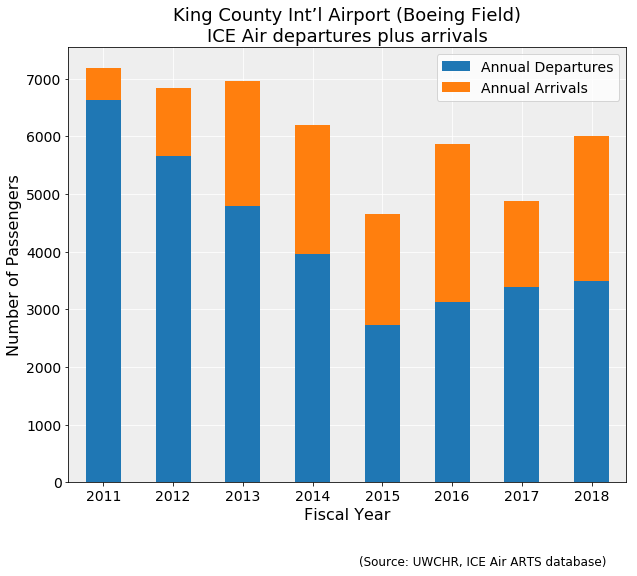

In [83]:
data = annual_summary[['Annual Departures', 'Annual Arrivals']]
bar_chart(data, airport, airport_name, 'pickup-dropoff',
         'King County Int’l Airport (Boeing Field)\nICE Air departures plus arrivals')
plt.show()

In [84]:
annual_summary[['Annual Departures', 'Annual Arrivals']].to_csv(f'../output/{airport}-AnnualDeparturesArrivals.csv')

In [85]:
all_df.to_csv(f'../output/{airport}-allpassengers.csv')

# Annual pickup rate, by criminal conviction status

WARNING: Criminal conviction data is not consistently recorded by ICE, especially in FY 11.

In [86]:
annual_non_criminal = pickup_df[['NonCriminal']].resample('AS-OCT').sum()

In [87]:
annual_non_criminal['total'] = annual_pickups
annual_non_criminal['percent'] = annual_non_criminal['NonCriminal']/annual_pickups*100

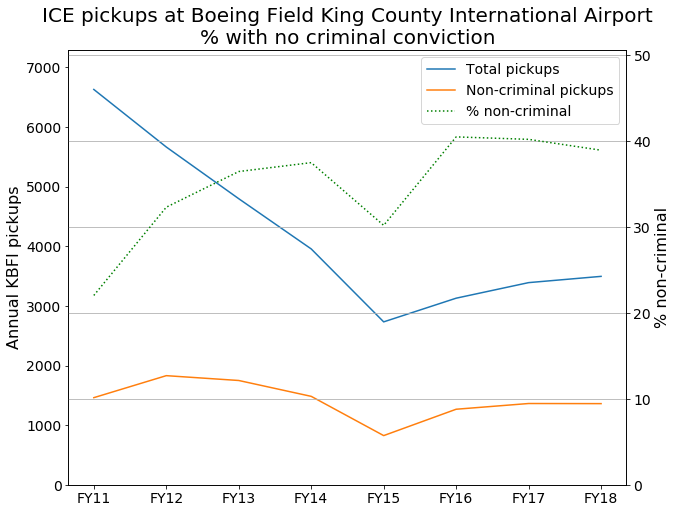

In [88]:
annual_data = annual_non_criminal['2010':'2017']
annual_data.index = [f'FY{str(x)[2:4]}' for x in range(2011,2019)]

# plt.style.use([{'legend.frameon': True}])
plt.rc("font", family="Sans-Serif")

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

lns1 = ax1.plot(annual_data['total'], label='Total pickups')
lns2 = ax1.plot(annual_data['NonCriminal'], label='Non-criminal pickups')
ax1_max = annual_data['total'].max()
ax1.set_ylim(0, (ax1_max * 1.1))
ax1.set_ylabel(f'Annual {airport} pickups', fontsize=16)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

lns3 = ax2.plot(annual_data['percent'], label='% non-criminal', linestyle=':', color='green')
ax2_max = annual_data['percent'].max()
ax2.set_ylim(0, (ax2_max * 1.25))
ax2.set_ylabel('% non-criminal', fontsize=16)
ax2.tick_params(axis='y', labelsize=14)
ax2.grid(None)
# ax2.set_xticklabels([f'FY{str(x)[2:4]}' for x in range(2011,2019)])

lns = [lns1[0], lns2[0], lns3[0]]
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0, fontsize=14)

ax1.set_title(f'ICE pickups at {airport_name}\n% with no criminal conviction', fontsize=20)

fig.set_size_inches(10, 8)

plt.show()
fig.savefig(f'../output/{airport}_NoCrim.png', dpi=100)

# Monthly averages (by FY)

Calculating average rates of pickups, dropoffs, and flights for each calendar year in the dataset.

In [89]:
monthly_means = pd.DataFrame()
for year in range(2010, 2019):
    mean_pickups = monthly_pickups[f'{year}'].mean()
    mean_pickup_missions = monthly_pickup_missions[f'{year}'].mean()
    mean_dropoffs = monthly_dropoffs[f'{year}'].mean()
    mean_dropoff_missions = monthly_dropoff_missions[f'{year}'].mean()
    monthly_means = monthly_means.append({'calendar_year':year,
                                          'monthly_mean_pickups':mean_pickups,
                                          'monthly_mean_dropoffs':mean_dropoffs,
                                          'monthly_mean_pickup_missions':mean_pickup_missions,
                                          'monthly_mean_dropoff_missions':mean_dropoff_missions,
                                         }, ignore_index=True)
monthly_means['calendar_year'] = monthly_means['calendar_year'].astype(int)
monthly_means = monthly_means.set_index('calendar_year')

In [90]:
monthly_means.round(2)

,monthly_mean_dropoff_missions,monthly_mean_dropoffs,monthly_mean_pickup_missions,monthly_mean_pickups
calendar_year,,,,
2010,4.00,39.33,7.67,512.67
2011,4.42,59.00,8.33,544.17
2012,3.92,115.42,4.83,450.17
2013,3.17,165.25,4.08,383.58
2014,3.83,161.92,3.92,300.00
2015,3.17,209.00,2.83,237.67
2016,4.17,231.50,4.50,264.83
2017,3.50,120.92,4.25,288.50
2018,3.75,193.08,4.17,273.17


In [91]:
monthly_means.to_csv(f'../output/{airport}_monthly_means.csv')

# Top nationalities

In [92]:
pickup_df.drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(10)

MEXICO                25133
GUATEMALA              3366
EL SALVADOR            2660
HONDURAS               2023
HAITI                   459
ECUADOR                 171
NICARAGUA               116
CAMBODIA                109
COLOMBIA                 51
DOMINICAN REPUBLIC       35
Name: CountryOfCitizenship, dtype: int64

In [93]:
dropoff_df.drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(5)

EL SALVADOR    3430
GUATEMALA      2554
MEXICO         2278
HONDURAS       1786
INDIA          1513
Name: CountryOfCitizenship, dtype: int64

In [94]:
all_df.drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(5)

MEXICO         27411
EL SALVADOR     6090
GUATEMALA       5920
HONDURAS        3809
INDIA           1543
Name: CountryOfCitizenship, dtype: int64

In [95]:
nat_percent = (df.groupby(['CountryOfCitizenship'])['AlienMasterID'].nunique() / len(df)).sort_values(ascending=False)

In [96]:
airport_nat_percent = (all_df.groupby(['CountryOfCitizenship'])['AlienMasterID'].nunique() / len(all_df)).sort_values(ascending=False)

In [97]:
pd.DataFrame({'Nationality as percent of dataset': nat_percent,
              f'Nationality as percent of {airport}': airport_nat_percent}).to_csv(f'../output/{airport}_nationality_percent_comparison.csv')

In [98]:
removal_nationalities = removal_df.groupby([pd.Grouper(freq='AS-OCT'), 'CountryOfCitizenship'])['AlienMasterID'].nunique().unstack()
removal_nationalities.to_csv(f'../output/{airport}_removal_nationalities.csv')

# Chart of top nationalities per year

This chart shows the top five `CountryOfCitizenship` values for each fiscal year. It can be misleading because values are summed in "ALL OTHERS" for years in which a particular nationalitiy is not in the top 5, but it makes clear things like which years certain groups come into or leave the top 5.

Charts can be generated for pickups, dropoffs, removals, transfers, or all records.

In [99]:
# Strangely, copying a DataFrame doesn't copy DataFrame.name
# There's probably a better way to link dataframes to downstream chart labels, though
df_to_analyze = pickup_df.copy()
df_to_analyze.name = pickup_df.name

In [100]:
g = df_to_analyze.groupby([pd.Grouper(freq='AS-OCT', sort=True), 'CountryOfCitizenship'])['AlienMasterID', 'MissionID'].nunique()
country_of_citizenship_by_year = g.reset_index()
country_of_citizenship_by_year.rename({'MissionDate': 'FY'}, axis='columns', inplace=True)
country_of_citizenship_by_year.set_index('FY', inplace=True)
country_of_citizenship_by_year.sort_values(by='AlienMasterID', ascending=False, inplace=True)

# country_of_citizenship_by_year.to_csv(f'../output/{airport}_country_of_citizenship_by_year.csv', index=True)

In [101]:
# Limiting to fiscal years with full data (FY2011-FY2018).
country_of_citizenship_by_year = country_of_citizenship_by_year['2010':'2017']

In [102]:
all_passenger_nationality_by_year = country_of_citizenship_by_year.groupby([pd.Grouper(freq='AS-OCT'),'CountryOfCitizenship'])[['AlienMasterID']].sum().dropna(how='all',axis=0).unstack()
all_passenger_nationality_by_year.to_csv(f'../output/{airport}_all_passenger_nationality_by_year.csv')

In [103]:
all_passenger_nationality_by_year.loc['2016':'2017'].T.dropna(how='all').to_csv('../output/kbfi_pickups_by_nationality.csv')

In [104]:
top_5_df = pd.DataFrame()

for year in country_of_citizenship_by_year.index.unique():
    temp = country_of_citizenship_by_year.loc[f'{year}'][['CountryOfCitizenship', 'AlienMasterID']]
    temp_top_5 = temp[0:5]
    if len(temp) > 5:
        all_other_count = sum(temp['AlienMasterID'][5:])
    else:
        all_other_count = 0
    other_df = pd.DataFrame([['ALL OTHERS', all_other_count]], columns=['CountryOfCitizenship', 'AlienMasterID'], index=[year])
    temp_top_5 = temp_top_5.append(other_df)
    top_5_df = top_5_df.append(temp_top_5)
    
top_5_df.sort_index(inplace=True)
top_5_df.index = [f'FY{str(x)[2:4]}' for x in top_5_df.index.year + 1]

top_5_data = pd.pivot_table(data=top_5_df,
                       index=top_5_df.index,
                       columns='CountryOfCitizenship',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)

top_5_data = top_5_data.reindex(top_5_data.sum().sort_values(ascending=False).index, axis=1)
cols = list(top_5_data.columns)
cols.remove('ALL OTHERS')
cols.append('ALL OTHERS')
top_5_data = top_5_data[cols]

top_5_data.columns = top_5_data.columns.str.title()
top_5_data.columns.name = 'Country of Citizenship'

In [105]:
def country_of_citizenship_trend(data, title=str, filename=str, xlabel=str, ylabel=str):
    
    fig, ax = plt.subplots()
    
    data.plot(kind='bar', stacked=True, legend=True, ax=ax).legend(bbox_to_anchor=(1,1))

    ax.set_axisbelow(True)
    ax.set_facecolor('#EEEEEE')
    ax.grid(color='#FFFFFF')
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_title(title, fontsize=18)
    ax.tick_params(labelsize=14)
    plt.xticks(rotation=0)
    txt='(Source: UWCHR, ICE Air ARTS database)'
    plt.figtext(0.7, -0.00, txt, wrap=True, horizontalalignment='center', fontsize=12)
    plt.legend(fontsize=12)

    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/{filename}.png', dpi=100, bbox_inches='tight')
    return fig, ax

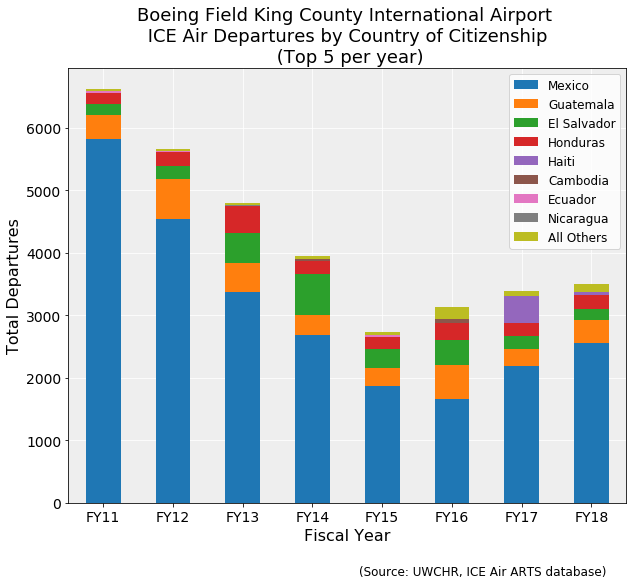

In [106]:
country_of_citizenship_trend(top_5_data,
                             title=f'{airport_name} \n ICE Air {df_to_analyze.name} by Country of Citizenship \n (Top 5 per year)',
                             filename=f'{airport}_top5_nationalities',
                             ylabel=f'Total {df_to_analyze.name}',
                             xlabel='Fiscal Year');

In [107]:
g = pickup_df.groupby(['PULOC', pd.Grouper(freq='AS-OCT', sort=True), 'air2_AirportName'])['AlienMasterID','MissionID'].nunique()
drop_locs_by_year = g.reset_index()
drop_locs_by_year.rename({'MissionDate': 'FY'}, axis='columns', inplace=True)

# drop_locs_by_year.to_csv(f'../output/{airport}_drop_locs_by_year.csv', index=True)

# Alternate plot of top nationalities

Since selecting top 5 for each year is a bit counterintuitive, we can instead select here an aribtrary number of nationalities to display for all years, while summing others. This can be based on most common values or could be some other arbitrary list. (See also implementation in `global.ipynb` for plotting all values that break top 5 for any year.)

In [108]:
annual = df_to_analyze.groupby([pd.Grouper(freq='AS-OCT', sort=True), 'CountryOfCitizenship'])['AlienMasterID'].nunique()

In [109]:
# There is probably a better way to do this
annual = annual.reset_index()
annual.set_index('MissionDate', inplace=True)
annual = annual['2010':'2017']

In [110]:
# Select arbitrary number of top values to display here
number_of_top_values = 5
annual_sum = annual.groupby(['CountryOfCitizenship'])['AlienMasterID'].sum()
top = list(annual_sum.sort_values(ascending=False).head(number_of_top_values).index)

top_df = pd.DataFrame()
top_df = top_df.append(annual[annual['CountryOfCitizenship'].isin(top)])
top_df.index = top_df.index.year

for year in annual.index.year.unique():
    temp = annual[f'{year}']
    temp2 = temp[~temp['CountryOfCitizenship'].isin(top)]
    all_other_count = temp2['AlienMasterID'].sum()
    other_df = pd.DataFrame([['ALL OTHERS', all_other_count]],
                            columns=['CountryOfCitizenship',
                                     'AlienMasterID'],
                            index=[year])
    top_df = top_df.append(other_df)

top_df.sort_index(inplace=True)
top_df.index = [f'FY{str(x)[2:4]}' for x in top_df.index + 1]

top_df['CountryOfCitizenship'] = top_df['CountryOfCitizenship'].astype('category')

top_data = pd.pivot_table(data=top_df,
                       index=top_df.index,
                       columns='CountryOfCitizenship',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)
top_data = top_data.reindex(top_data.sum().sort_values(ascending=False).index, axis=1)
cols = list(top_data.columns)
cols.remove('ALL OTHERS')
cols.append('ALL OTHERS')
top_data = top_data[cols]
top_data.columns = top_data.columns.astype(str)
top_data.columns = top_data.columns.str.title()

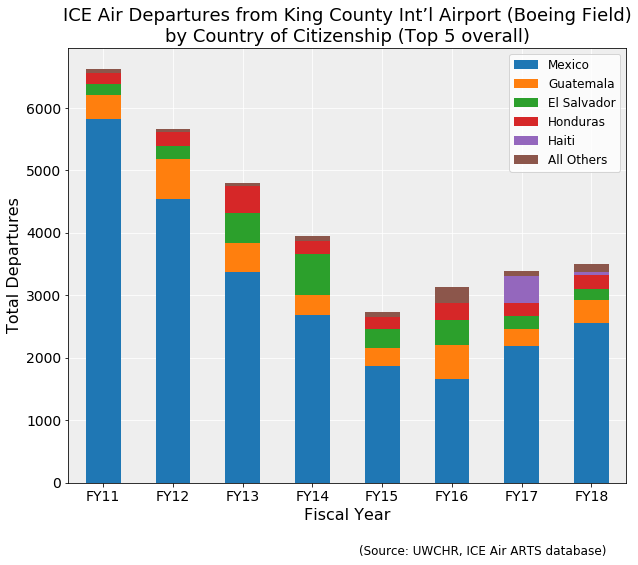

In [111]:
country_of_citizenship_trend(top_data,
                             title=f'ICE Air Departures from King County Int’l Airport (Boeing Field)\nby Country of Citizenship (Top 5 overall)',
                             filename=f'{airport}_pickup_nationalities',
                             ylabel=f'Total {df_to_analyze.name}',
                             xlabel='Fiscal Year');

# Juveniles (by fiscal year)

Table of just juveniles for pickups, dropoffs. Currently will fail if no juveniles.

In [112]:
assert sum(all_df['Juvenile']) > 0, f"No juveniles in dataset for {airport}"

In [113]:
g = pickup_df.groupby(['PULOC', pd.Grouper(freq='AS-OCT', sort=True), 'Juvenile'])['AlienMasterID'].nunique()
juvenile_pickups = g.unstack()
juvenile_pickups['percent'] = juvenile_pickups[True] / juvenile_pickups[False] * 100
juvenile_pickups

Juvenile            False  True   percent
PULOC MissionDate                        
KBFI  2010-10-01   6613.0  16.0  0.241948
      2011-10-01   5653.0  11.0  0.194587
      2012-10-01   4795.0   2.0  0.041710
      2013-10-01   3953.0   2.0  0.050594
      2014-10-01   2732.0   NaN       NaN
      2015-10-01   3129.0   NaN       NaN
      2016-10-01   3381.0   9.0  0.266193
      2017-10-01   3490.0   5.0  0.143266
      2018-10-01    652.0   NaN       NaN

In [114]:
g = dropoff_df.groupby(['DropLoc', pd.Grouper(freq='AS-OCT', sort=True), 'Juvenile'])['AlienMasterID'].nunique()
juvenile_pickups = g.unstack()

In [115]:
juvenile_pickups

Juvenile              False  True 
DropLoc MissionDate               
KBFI    2010-10-01    550.0    2.0
        2011-10-01   1172.0    3.0
        2012-10-01   2151.0    2.0
        2013-10-01   2177.0   70.0
        2014-10-01   1926.0    NaN
        2015-10-01   2737.0    NaN
        2016-10-01   1487.0    NaN
        2017-10-01   2504.0    NaN
        2018-10-01    410.0    NaN

In [116]:
juvenile_pickups['percent'] = juvenile_pickups[True] / juvenile_pickups[False] * 100
juvenile_pickups

Juvenile              False  True   percent
DropLoc MissionDate                        
KBFI    2010-10-01    550.0   2.0  0.363636
        2011-10-01   1172.0   3.0  0.255973
        2012-10-01   2151.0   2.0  0.092980
        2013-10-01   2177.0  70.0  3.215434
        2014-10-01   1926.0   NaN       NaN
        2015-10-01   2737.0   NaN       NaN
        2016-10-01   1487.0   NaN       NaN
        2017-10-01   2504.0   NaN       NaN
        2018-10-01    410.0   NaN       NaN

In [117]:
g = all_df.groupby(['R-T', pd.Grouper(freq='AS-OCT', sort=True), 'Juvenile'])['AlienMasterID'].nunique()

In [118]:
juvenile_removal_transfer = g.unstack()
juvenile_removal_transfer

Juvenile          False  True 
R-T MissionDate               
R   2010-10-01   5802.0   13.0
    2011-10-01   4629.0    9.0
    2012-10-01   2458.0    2.0
    2013-10-01    685.0    NaN
    2014-10-01    313.0    NaN
    2015-10-01    225.0    NaN
    2016-10-01    406.0    NaN
    2017-10-01   1071.0    4.0
    2018-10-01    452.0    NaN
T   2010-10-01   1361.0    5.0
    2011-10-01   2196.0    5.0
    2012-10-01   4488.0    2.0
    2013-10-01   5445.0   72.0
    2014-10-01   4345.0    NaN
    2015-10-01   5641.0    NaN
    2016-10-01   4462.0    9.0
    2017-10-01   4923.0    1.0
    2018-10-01    610.0    NaN

# Detainee status

In [119]:
status_count = removal_df.drop_duplicates(subset='AlienMasterID')['Status'].str.upper().value_counts(dropna=False)

In [120]:
status = pd.read_csv('../../share/resources/status.csv')

valid_status_codes = list(status['Code'])

status_dict = dict(zip(status['Code'], status['Status']))

pending = ['2A', '2B', '8A', '8B', '8D']
benefit = ['5C', '5D']
expedited_admin_rein = ['8F', '8G', '8H', '8I', '11', '16']
problematic = pending + benefit + expedited_admin_rein

In [121]:
problematic_count = 0
valid = removal_df['Status'].str.upper().isin(valid_status_codes)
valid_count = sum(valid)
invalid = ~removal_df['Status'].str.upper().isin(valid_status_codes)
invalid_count = sum(invalid)

print(f'{airport} - {airport_name}')
print()
print(f'ICE status codes for passengers on direct removal flights.')
print(f'(Statuses which may raise due process concerns starred)')
print()
print(f'{valid_count} valid values.')
print(f'{invalid_count} invalid values.')
print()
for c in valid_status_codes:
    
    try:
        count = status_count[c]
    except KeyError:
        count = 0
    
    if c in problematic:
        problematic_count = problematic_count + count
        print(f'[{c}]: *{count}* ({status_dict[c]})')
    else:
        print(f'[{c}]: {count} ({status_dict[c]})')
print()
print(f'{problematic_count} problematic cases.')

KBFI - Boeing Field King County International Airport

ICE status codes for passengers on direct removal flights.
(Statuses which may raise due process concerns starred)

7528 valid values.
8541 invalid values.

[1A]: 2446 (Voluntary Departure – Un-Expired and Un-Extended Voluntary Departure.)
[1B]: 20 (Voluntary Departure - Extended Departure Period)
[1C]: 0 (Exipred Voluntary Departure Period - Referred to Investigation)
[2A]: *32* (Deportable – Under Adjudication by IJ)
[2B]: *1* (Deportable – Under Adjudication by BIA)
[3]: 161 (Deportable – Administratively Final Order)
[5A]: 1 (Referred for Investigation - No Show for Hearing - No Final O...)
[5B]: 20 (Removable – ICE Fugitive)
[5C]: *1* (Relief Granted – Withholding of Deportation/Removal)
[5D]: *1* (Final Order of Deportation/Removal – Deferred Action Granted.)
[5E]: 1 (Relief Granted – Extended Voluntary Departure)
[5F]: 0 (Unable to Obtain Travel Document)
[8A]: *31* (Excludable/Inadmissible – Hearing Not Commenced)
[8B]: *86

In [123]:
sum(removal_df['Status'].isin(expedited_admin_rein))

2615

In [124]:
sum(removal_df['Status'].isin(pending))

157

In [125]:
sum(removal_df['Status'].isin(benefit))

2

In [126]:
status_fy = removal_df.drop_duplicates(subset='AlienMasterID').resample('AS-OCT')['Status'].value_counts().unstack()
status_fy_valid = status_fy[status_fy.columns[status_fy.columns.isin(valid_status_codes)]]

total = removal_df.drop_duplicates(subset='AlienMasterID').resample('AS-OCT')['AlienMasterID'].nunique()

status_fy_valid.T.to_csv(f'../output/{airport}_valid_status_by_year.csv')

all_others = status_fy[status_fy.columns[~status_fy.columns.isin(valid_status_codes)]].sum(axis=1)
all_others.name = 'all_others'

status_table = pd.concat([status_fy_valid, all_others], axis=1).T

status_table.to_csv(f'../output/{airport}_removal_status_by_year.csv')
(status_table/total).to_csv(f'../output/{airport}_removal_status_by_year_percent.csv')

In [127]:
total

MissionDate
2010-10-01    5815
2011-10-01    4638
2012-10-01    2460
2013-10-01     685
2014-10-01     313
2015-10-01     225
2016-10-01     406
2017-10-01    1075
2018-10-01     452
Freq: AS-OCT, Name: AlienMasterID, dtype: int64

In [128]:
transfer_status = transfer_df['Status'].value_counts()

In [129]:
transfer_status[transfer_status >= 100]

8G                7935
16                7157
8F                5559
8C                3766
TRANSFER - F/O    2082
11                 998
NO STATUS          934
8A                 683
3                  590
12                 577
ER-TRANSFER        367
2A                 351
REMOVAL            334
1A                 331
TRANSFER - NTA     243
8B                 222
NTA                207
8E                 154
9                  139
Name: Status, dtype: int64

In [130]:
pickup_transfer_status = pickup_df[pickup_df['R-T'] == 'T']['Status'].value_counts()

In [131]:
pickup_transfer_status[pickup_transfer_status > 100]

16                5067
8C                3685
8F                2160
TRANSFER - F/O    1927
8G                1477
11                 989
12                 577
3                  472
1A                 328
REMOVAL            309
2A                 303
8B                 197
NO STATUS          152
8E                 147
9                  137
Name: Status, dtype: int64

In [132]:
dropoff_status = dropoff_df['Status'].value_counts()
dropoff_status[dropoff_status > 1]

8G                  6477
8F                  3404
16                  2092
NO STATUS            782
8A                   612
ER-TRANSFER          367
TRANSFER - NTA       221
NTA                  207
TRANSFER - F/O       155
3                    118
TRANSFER-NTA          98
TRANSFER              95
8C                    81
REINSTATE             61
NTA-TRANSFER          59
2A                    48
NTA-NEW               32
REMOVAL               25
8B                    25
X-NTA                 16
1/15/1900             14
8D                    12
RF                    11
10                    11
TRANSFER/SEA          10
5F                    10
T-NTA                 10
TRANSFER -             9
11                     9
ER-NEW                 9
2B                     7
8E                     7
RM                     7
ER/CRE.FR.             6
WA/NTA                 5
RR-TRANSFER            4
TRAN-NTA               4
5B                     4
BIA PEND               3
BIA APP                3


## Finding most common day of week

In [133]:
all_df['MissionWeekday'] = all_df.index.weekday

In [134]:
index = range(0,7)

In [135]:
weekdays_2018 = all_df.loc['2018'].groupby(['MissionWeekday'])['MissionID'].nunique()

In [136]:
weekdays_2018 = weekdays_2018.reset_index()

In [137]:
weekdays_2018 = weekdays_2018.set_index('MissionWeekday')

In [138]:
weekdays_2018 = weekdays_2018.reindex(index=index)

In [139]:
weekdays_2018 = weekdays_2018.rename({'MissionID': 'Flights'}, axis=1)

In [140]:
weekdays_2018 = weekdays_2018.T
weekdays_2018.columns = ['M', 'Tu', 'W', 'Th', 'F', 'Sa', 'Su']

In [141]:
weekdays_2018.fillna(0, inplace=True)

In [142]:
weekdays_2018

,M,Tu,W,Th,F,Sa,Su
Flights,1.0,47.0,0.0,0.0,1.0,1.0,2.0


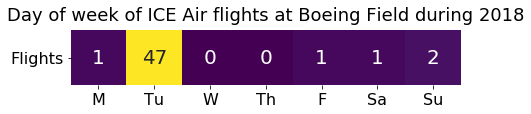

In [143]:
fig, ax = plt.subplots()
fig.set_size_inches(7,1)
ax = sns.heatmap(weekdays_2018, annot=True, annot_kws={"size": 20}, fmt='.0f', cmap=plt.cm.viridis, cbar=False)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16, rotation=0)
# ax.set_ylabel('Year', fontsize=14)
# ax.set_xlabel('Weekday', fontsize=14)
ax.set_title('Day of week of ICE Air flights at Boeing Field during 2018', fontsize=18, pad=10);
fig.savefig(f'../output/{airport}-weekdays.png', dpi=100,  bbox_inches='tight')

# Airport report

For a each airport ICAO code represented in the ICE Air data, output a uniform set of variables, tables, and figures.

In [149]:
airport_dict['KBFI']['AirportName']

'Boeing Field King County International Airport'

In [150]:
def airport_report(airport_icao, print_report=False, figure=False):
    airport = airport_icao
    if airport.upper() in airport_dict.keys():
        pass
    else:
        print(f'{airport} not represented in dataset')
    airport_name = airport_dict[airport]['AirportName']
    pickup = df['PULOC'] == airport
    dropoff = df['DropLoc'] == airport

    pickup_df = df[pickup]
    dropoff_df = df[dropoff]

    first_pickup = pickup_df.MissionDate.min()
    last_pickup = pickup_df.MissionDate.max()
    first_dropoff = dropoff_df.MissionDate.min()
    last_dropoff = dropoff_df.MissionDate.max()

    pickup_df.set_index('MissionDate', inplace=True)
    dropoff_df.set_index('MissionDate', inplace=True)

    all_df = pd.concat([pickup_df, dropoff_df]).drop_duplicates()

    removal = all_df['R-T'] == 'R'
    transfer = all_df['R-T'] == 'T'
    removal_df = all_df[removal]
    transfer_df = all_df[transfer]

    all_df.name = 'Passengers'
    removal_df.name = 'Removals'
    transfer_df.name = 'Transfers'
    pickup_df.name = 'Pickups'
    dropoff_df.name = 'Dropoffs'

    # This grouped table would work for mapping flights from specific airports.
    all_missions = all_df.groupby(['MissionDate', 'MissionID', 'PULOC', 'DropLoc'])[['AlienMasterID']].nunique()
    
    monthly_pickups = pickup_df['AlienMasterID'].resample('M').nunique()
    monthly_dropoffs = dropoff_df['AlienMasterID'].resample('M').nunique()
    monthly_pickup_missions = pickup_df['MissionID'].resample('M').nunique()
    monthly_dropoff_missions = dropoff_df['MissionID'].resample('M').nunique()
    annual_pickups = pickup_df['AlienMasterID'].resample('AS-OCT').nunique()
    annual_dropoffs = dropoff_df['AlienMasterID'].resample('AS-OCT').nunique()
    annual_removals = removal_df['AlienMasterID'].resample('AS-OCT').nunique()
    annual_transfers = transfer_df['AlienMasterID'].resample('AS-OCT').nunique()
    annual_pickup_missions = pickup_df['MissionID'].resample('AS-OCT').nunique()
    annual_dropoff_missions = dropoff_df['MissionID'].resample('AS-OCT').nunique()
    
    unique_pickups = len(set(pickup_df['AlienMasterID']))
    unique_dropoffs = len(set(dropoff_df['AlienMasterID']))
    unique_removals = len(set(removal_df['AlienMasterID']))
    unique_transfers = len(set(transfer_df['AlienMasterID']))
    total_unique = len(set(all_df['AlienMasterID']))
    removal_percent = round(unique_removals / total_unique * 100, 2)
    transfer_percent = round(unique_transfers / total_unique * 100, 2)
    monthly_dropoff_avg = round(monthly_dropoffs.mean(), 2)
    monthly_pickup_avg = round(monthly_pickups.mean(), 2)
    monthly_dropoff_mission_avg = round(monthly_dropoff_missions.mean(), 2)
    monthly_pickup_mission_avg = round(monthly_pickup_missions.mean(), 2)
    unique_pickup_missions = len(set(pickup_df['MissionID']))
    unique_dropoff_missions = len(set(dropoff_df['MissionID']))
    
    airport_vars = {airport:
                {'airport_name': airport_name,
                'unique_pickups': unique_pickups,
                'unique_dropoffs': unique_dropoffs,
                'unique_removals': unique_removals,
                'unique_transfers': unique_transfers,
                'total_unique': total_unique,
                'removal_percent': removal_percent,
                'transfer_percent': transfer_percent,
                'monthly_dropoff_avg': monthly_dropoff_avg,
                'monthly_pickup_avg': monthly_pickup_avg,
                'monthly_dropoff_mission_avg': monthly_dropoff_mission_avg,
                'monthly_pickup_mission_avg': monthly_pickup_mission_avg,
                'unique_pickup_missions': unique_pickup_missions,
                'unique_dropoff_missions': unique_dropoff_missions}}
    
    row = pd.DataFrame(airport_vars).T
    
    if print_report == True:
        print(f'{airport} ({airport_name})')
        print(f'---------------------------------------------------------')
        print(f'{unique_pickups} passengers picked up, {unique_dropoffs} passengers dropped off.')
        print(f'{unique_removals} removals, {unique_transfers} transfers.')
        print(f"{total_unique} total unique passengers.")
        print(f"{removal_percent}% removals, {transfer_percent}% transfers")
        print(f'{monthly_dropoff_avg} average dropoffs per month.')
        print(f'{monthly_pickup_avg} average pickups per month.')
        print()
        print(f'{unique_pickup_missions} pickup missions, {unique_dropoff_missions} dropoff missions.')
        print(f"{all_df['MissionID'].nunique()} total missions.")
        print(f'{monthly_dropoff_mission_avg} average dropoff missions per month.')
        print(f'{monthly_pickup_mission_avg} average pickup missions per month.')
        print(f'First pickup mission: {first_pickup}; Last pickup flight: {last_pickup}')
        print(f'First dropoff mission: {first_dropoff}; Last dropoff mission: {last_dropoff}')

    if figure == True:
        fy_index = pd.date_range(start='2010-10-01', end='2018-01-01', freq='AS-OCT')
        annual_removals.rename('Total removals', inplace=True)
        annual_transfers.rename('Total transfers', inplace=True)
        annual_summary = pd.DataFrame({
              'Annual Removals': annual_removals,
              'Annual Transfers': annual_transfers}, index=fy_index)
        annual_summary.index = annual_summary.index.year+1 
        annual_summary.index.name = 'Fiscal Year'
        data = annual_summary[['Annual Removals', 'Annual Transfers']]
        bar_chart(data, airport, airport_name, '_R-T')

    return(row)

In [151]:
airport_df = pd.DataFrame()
for key in airport_dict.keys():
    try:
        row = airport_report(key)
    except AttributeError:
        pass
    airport_df = airport_df.append(row)
airport_df.to_csv('../output/all_airport_vars.csv')

In [152]:
airport_df.head()

,airport_name,monthly_dropoff_avg,monthly_dropoff_mission_avg,monthly_pickup_avg,monthly_pickup_mission_avg,removal_percent,total_unique,transfer_percent,unique_dropoff_missions,unique_dropoffs,unique_pickup_missions,unique_pickups,unique_removals,unique_transfers
BKPR,Pristina International Airport,0.06,0.05,NaN,NaN,100,4,0,3,4,0,0,4,0
DAAG,Houari Boumediene Airport,3,1,NaN,NaN,100,3,0,1,3,0,0,3,0
DFFD,Ouagadougou Airport,5,1,NaN,NaN,100,5,0,1,5,0,0,5,0
DGAA,Kotoka International Airport,3.76,0.09,NaN,NaN,100,350,0,8,350,0,0,350,0
DIAP,Port Bouet Airport,0.32,0.06,NaN,NaN,100,31,0,6,31,0,0,31,0


In [155]:
airport_df.loc['KBFI']

airport_name                   Boeing Field King County International Airport
monthly_dropoff_avg                                                    153.44
monthly_dropoff_mission_avg                                              3.75
monthly_pickup_avg                                                     347.91
monthly_pickup_mission_avg                                               4.71
removal_percent                                                         32.37
total_unique                                                            49634
transfer_percent                                                        67.63
unique_dropoff_missions                                                   371
unique_dropoffs                                                         15191
unique_pickup_missions                                                    466
unique_pickups                                                          34443
unique_removals                                                 

KELP (El Paso International Airport)
---------------------------------------------------------
136127 passengers picked up, 87186 passengers dropped off.
122665 removals, 100404 transfers.
223069 total unique passengers.
54.99% removals, 45.01% transfers
880.67 average dropoffs per month.
1375.02 average pickups per month.

2315 pickup missions, 1926 dropoff missions.
3045 total missions.
19.45 average dropoff missions per month.
23.38 average pickup missions per month.
First pickup mission: 2010-10-01 00:00:00; Last pickup flight: 2018-12-04 00:00:00
First dropoff mission: 2010-10-04 00:00:00; Last dropoff mission: 2018-12-04 00:00:00


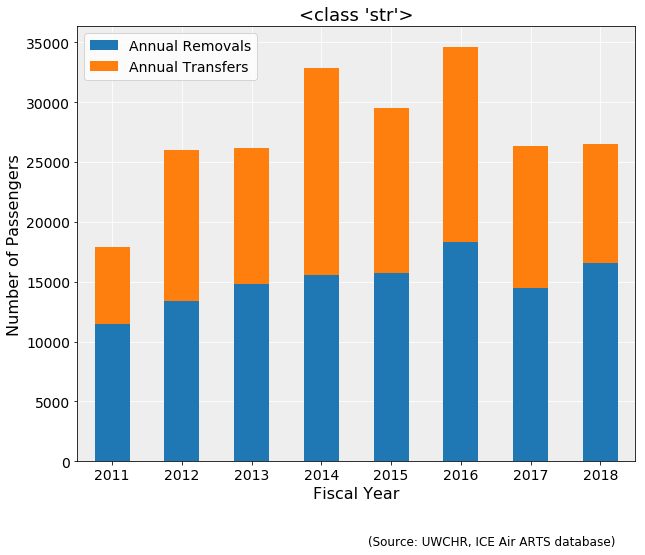

,airport_name,monthly_dropoff_avg,monthly_dropoff_mission_avg,monthly_pickup_avg,monthly_pickup_mission_avg,removal_percent,total_unique,transfer_percent,unique_dropoff_missions,unique_dropoffs,unique_pickup_missions,unique_pickups,unique_removals,unique_transfers
KELP,El Paso International Airport,880.67,19.45,1375.02,23.38,54.99,223069,45.01,1926,87186,2315,136127,122665,100404


In [153]:
airport_report('KELP', print_report=True, figure=True)

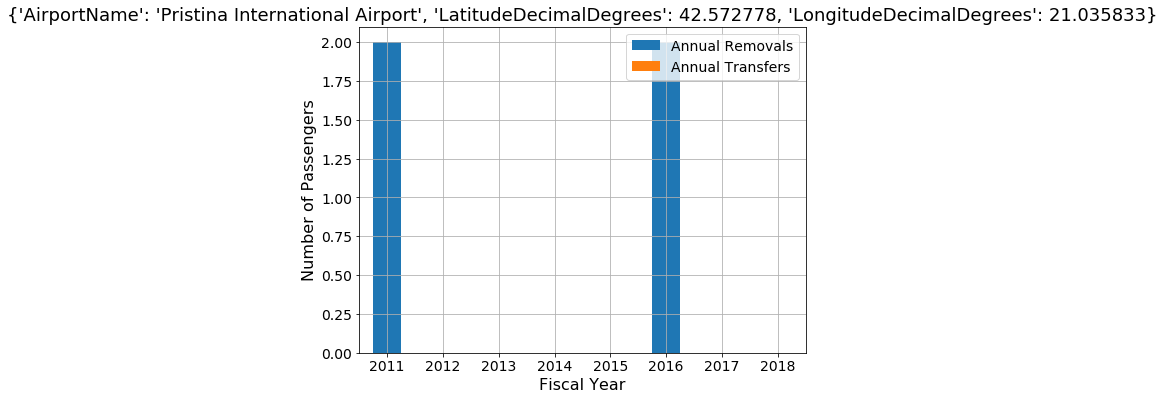

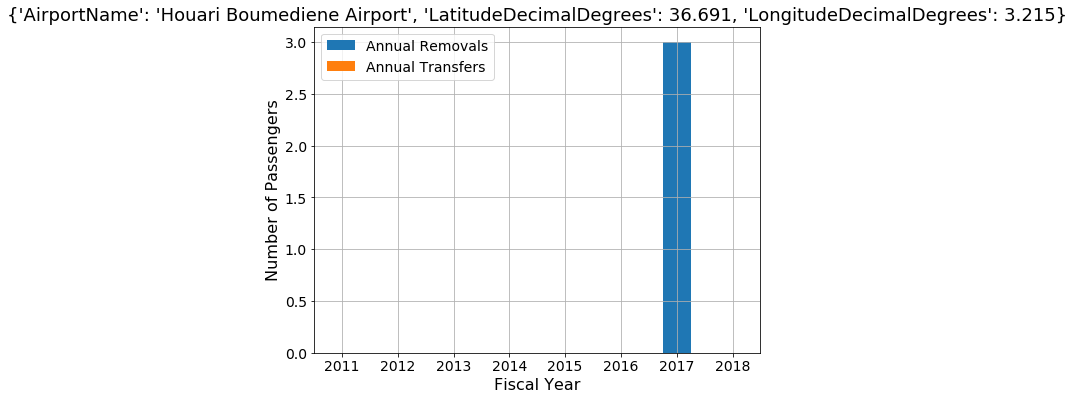

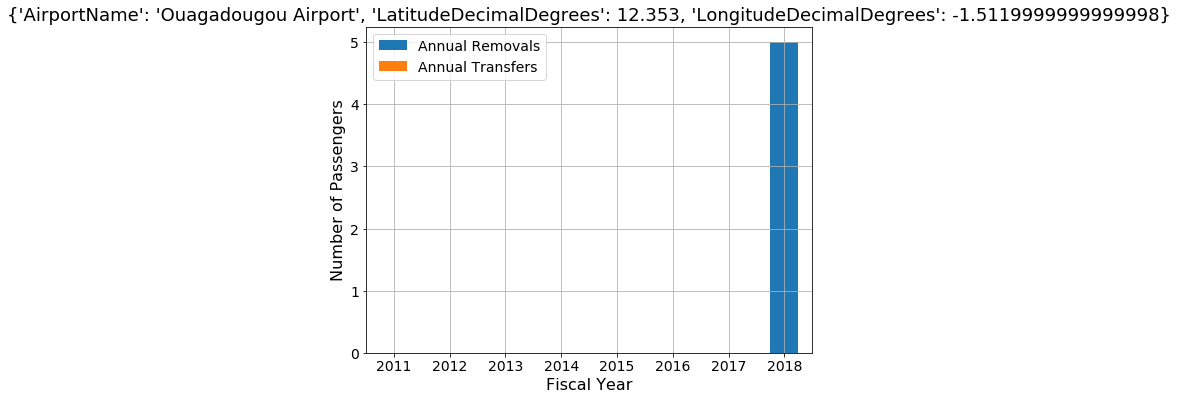

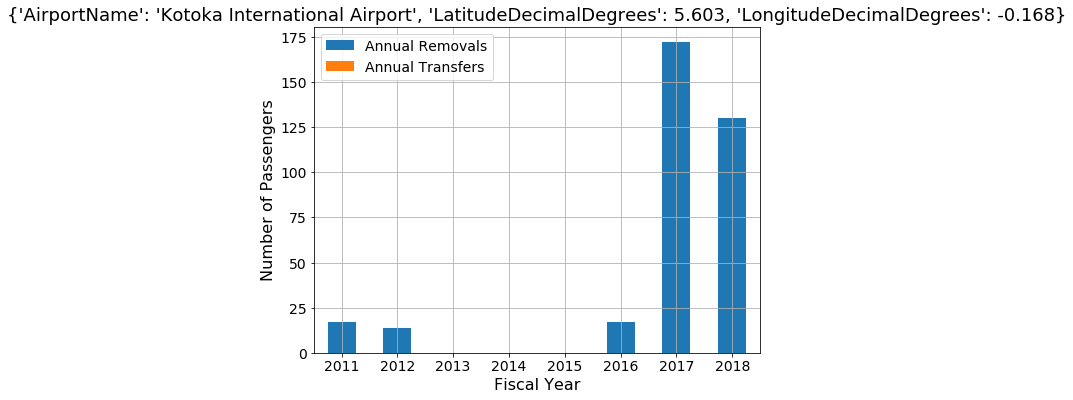

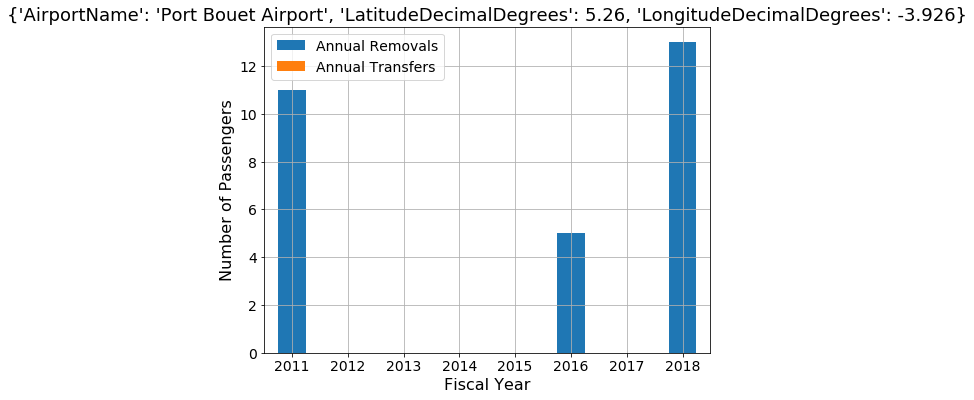

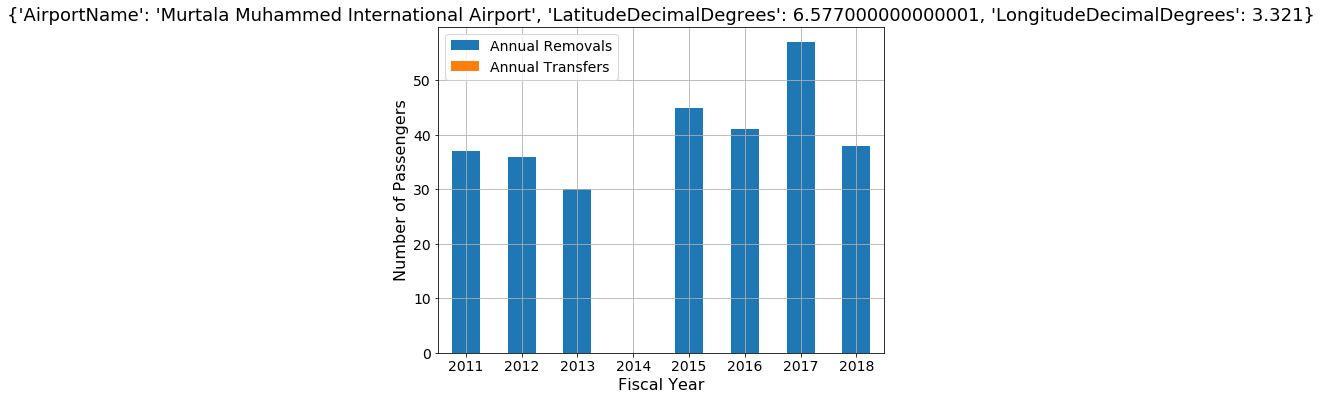

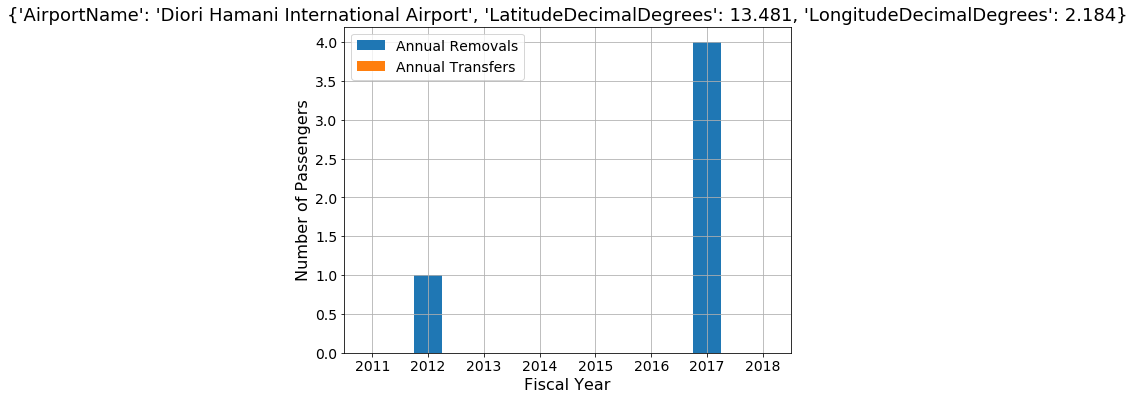

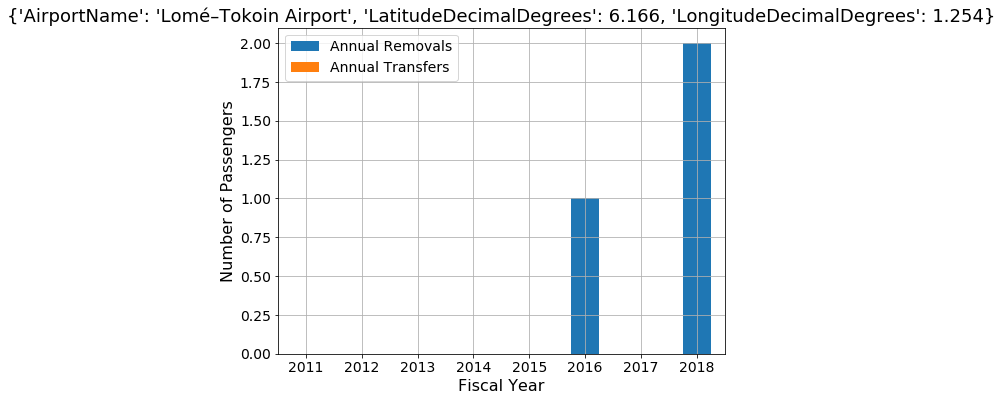

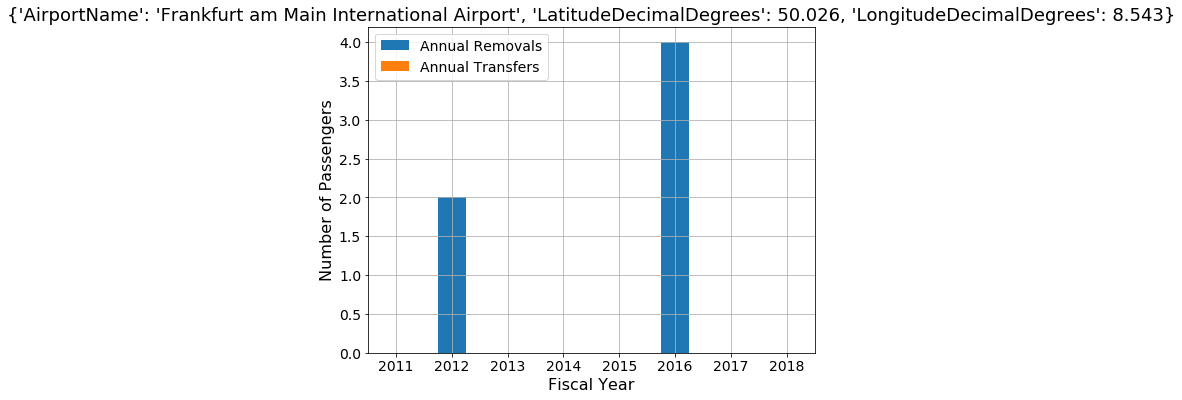

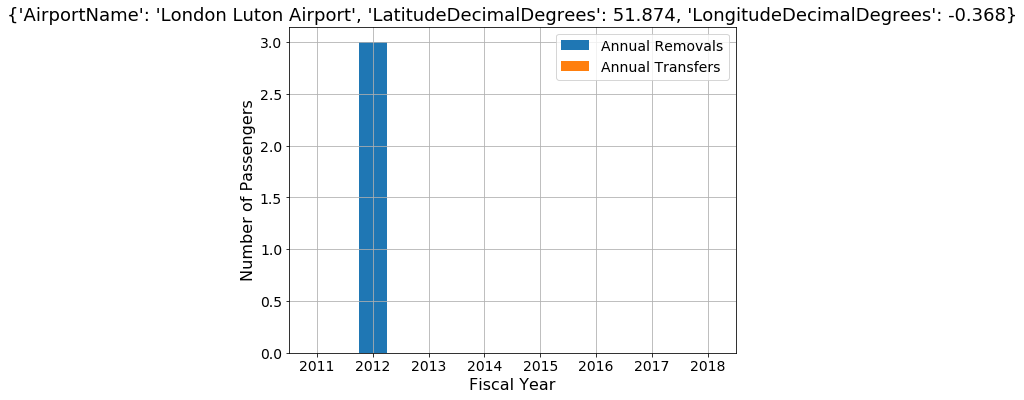

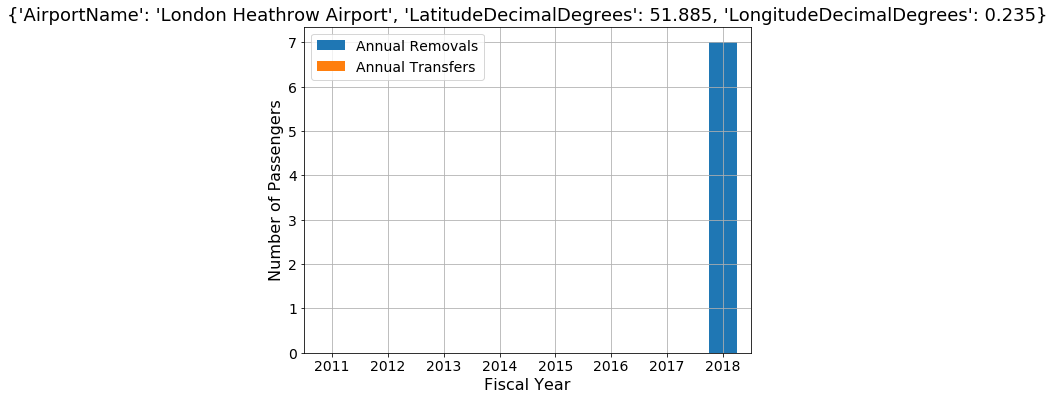

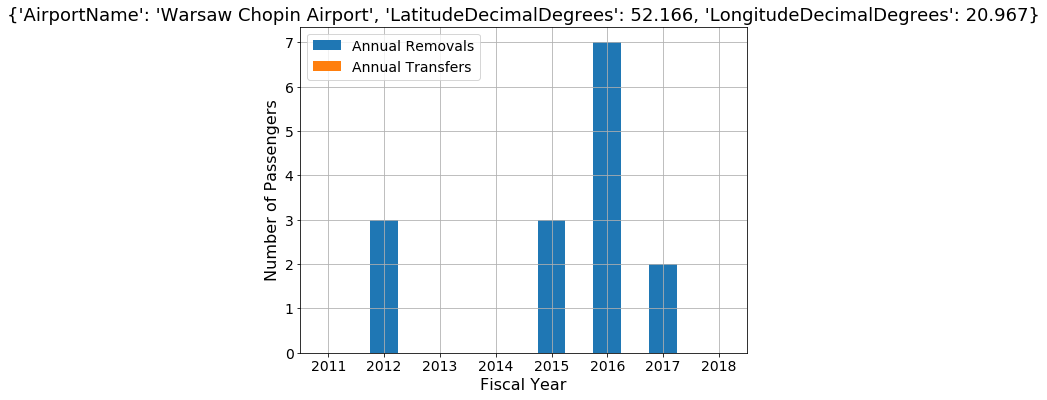

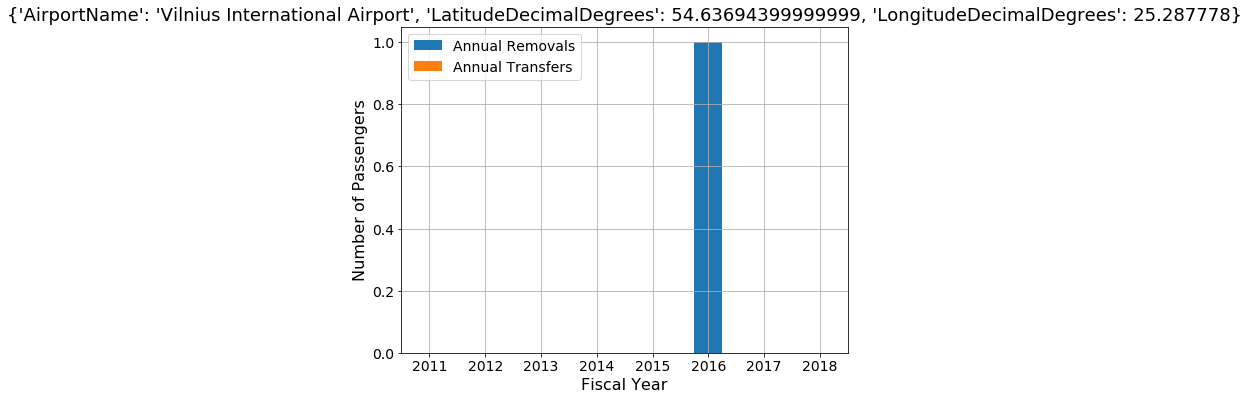

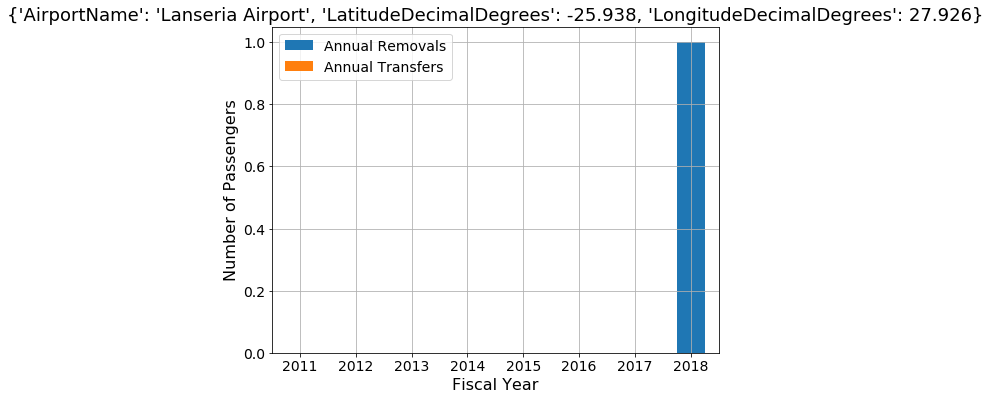

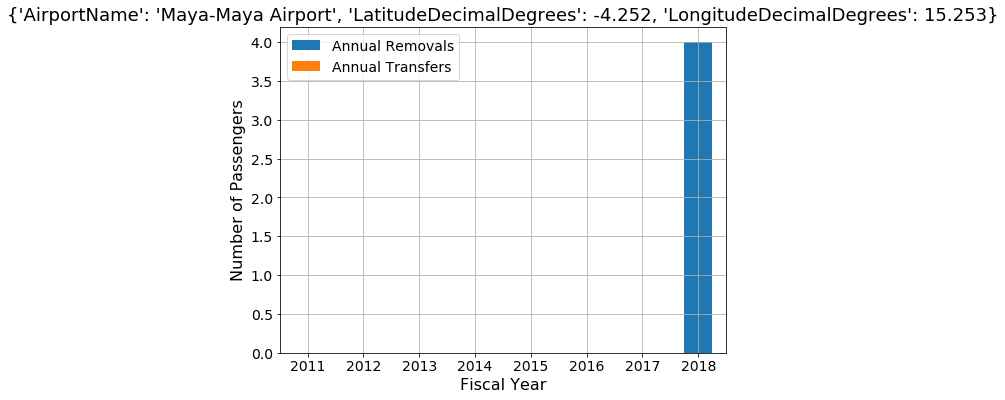

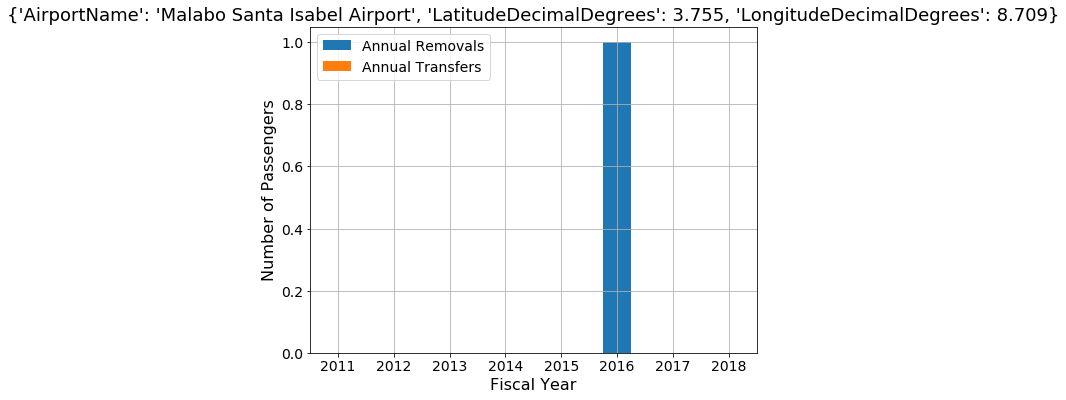

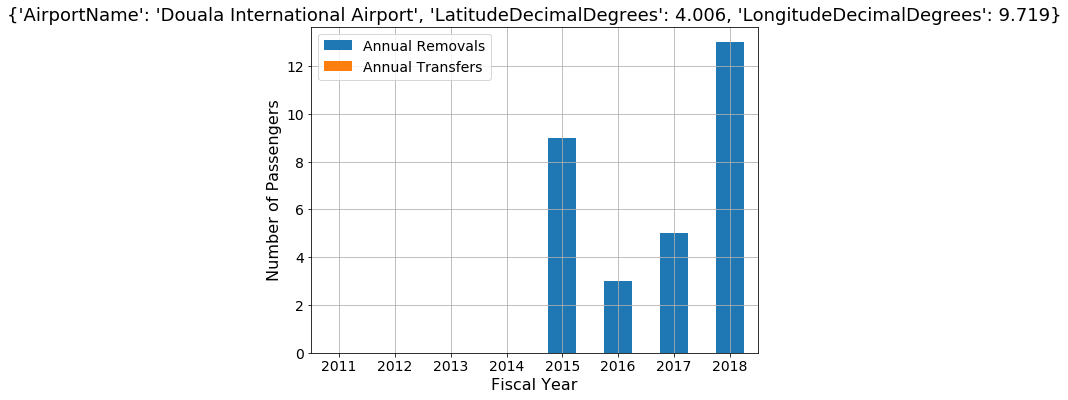

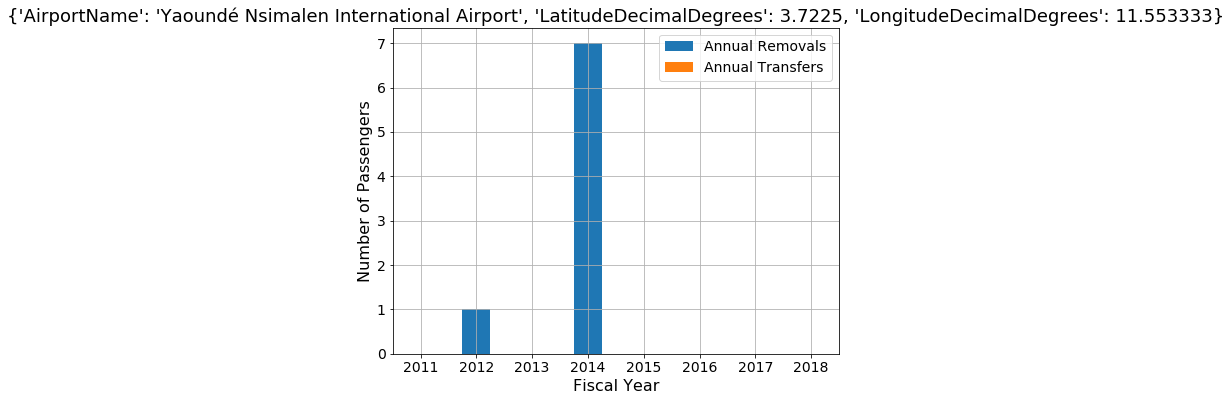

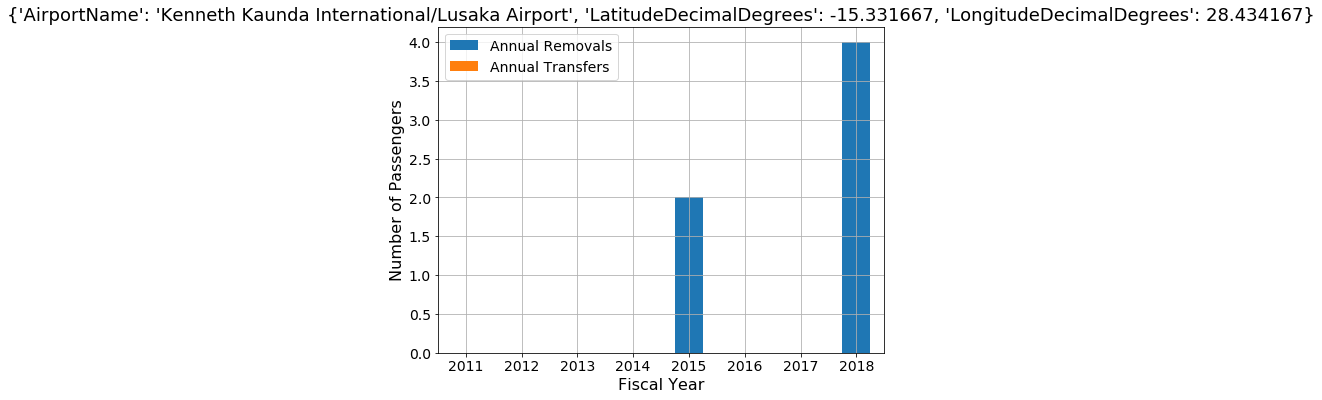

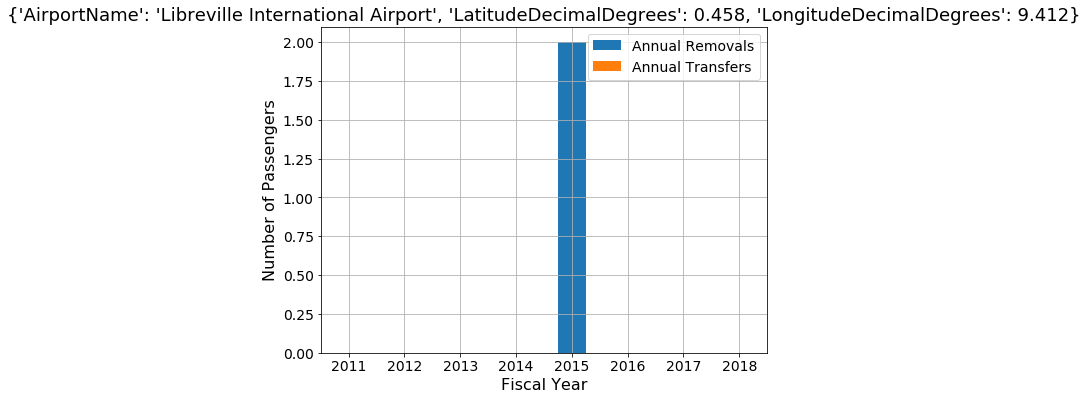

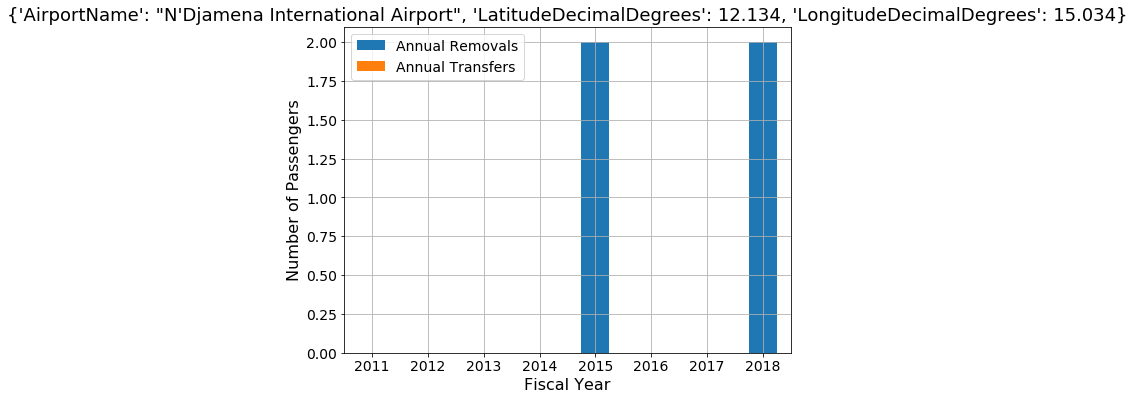

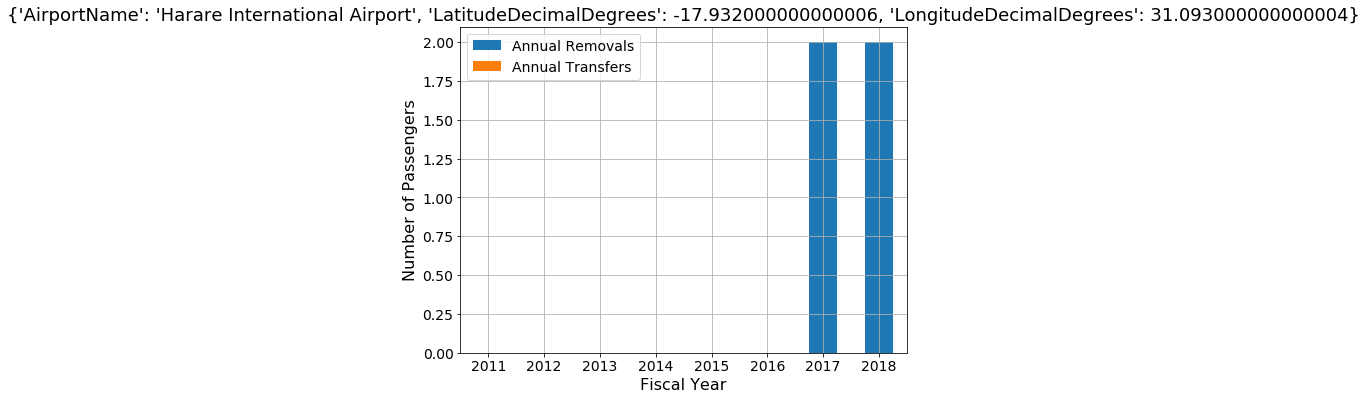

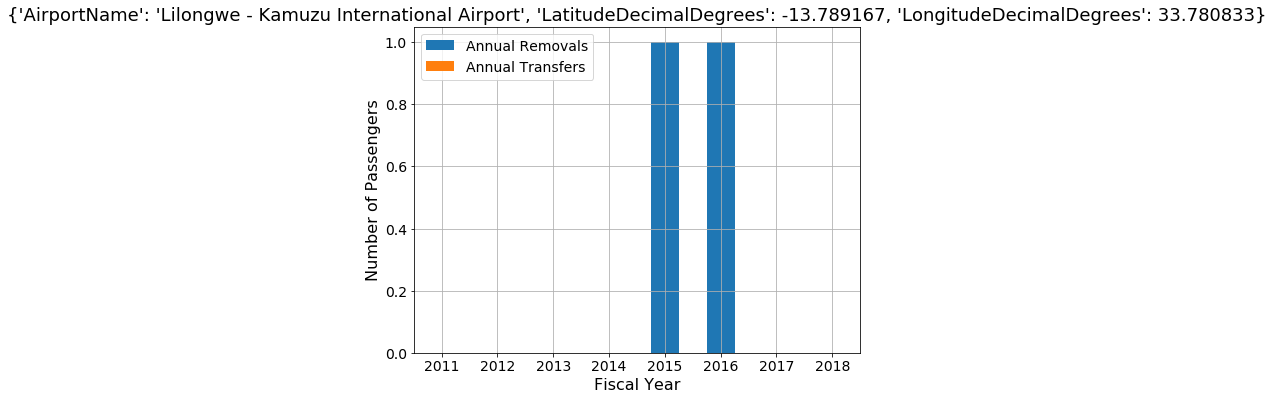

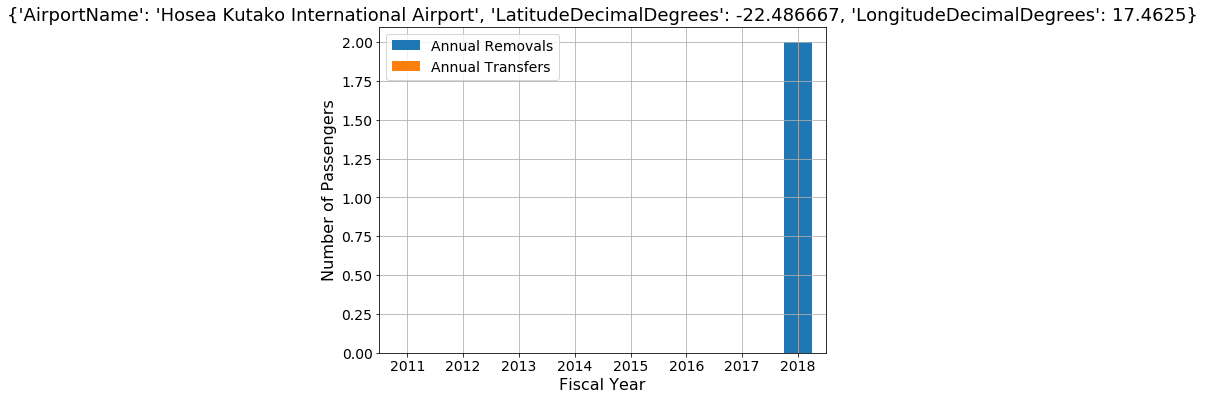

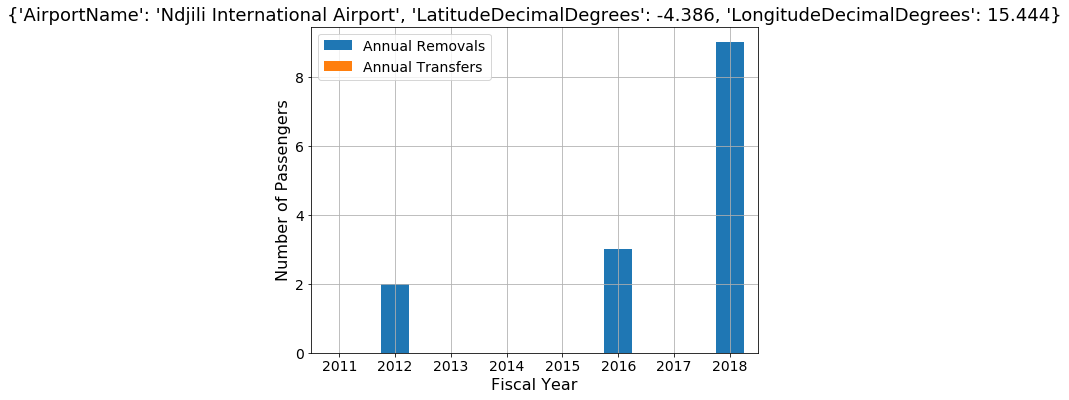

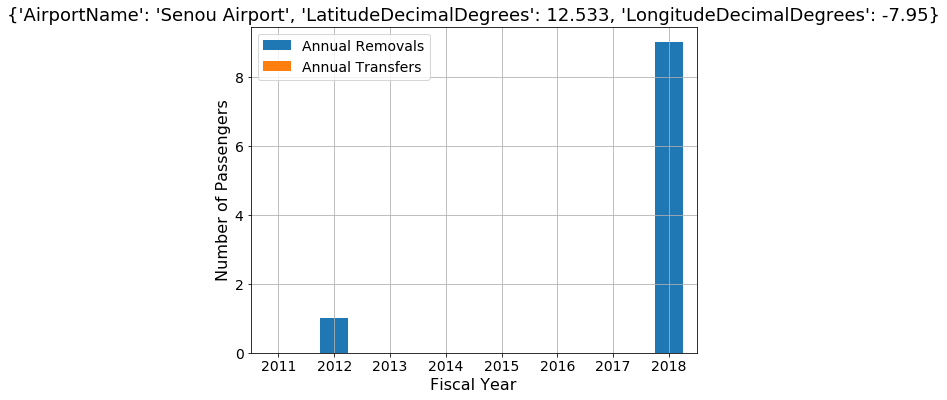

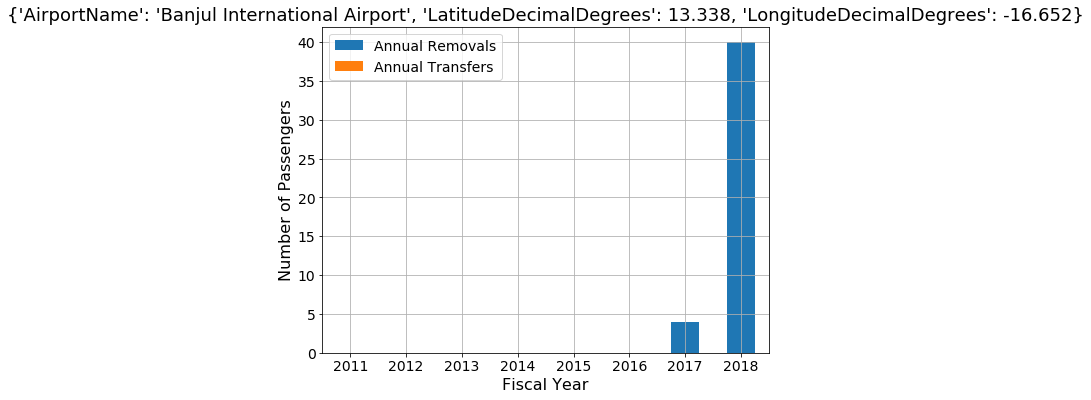

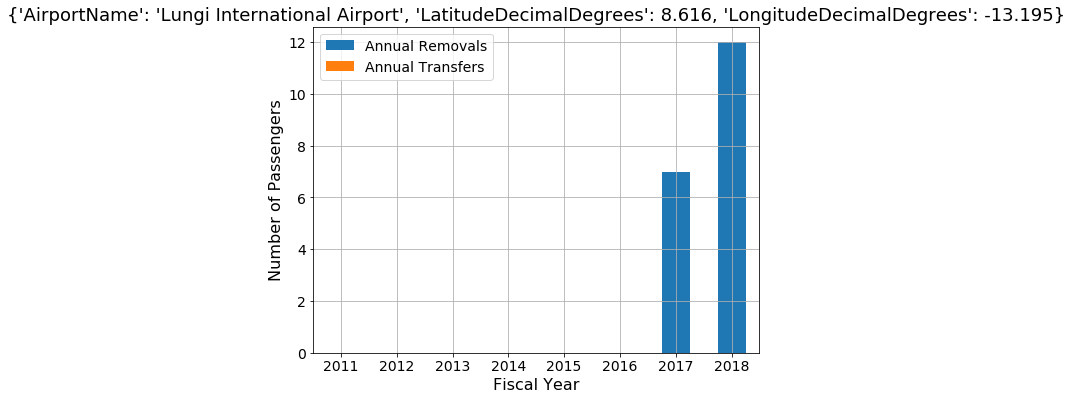

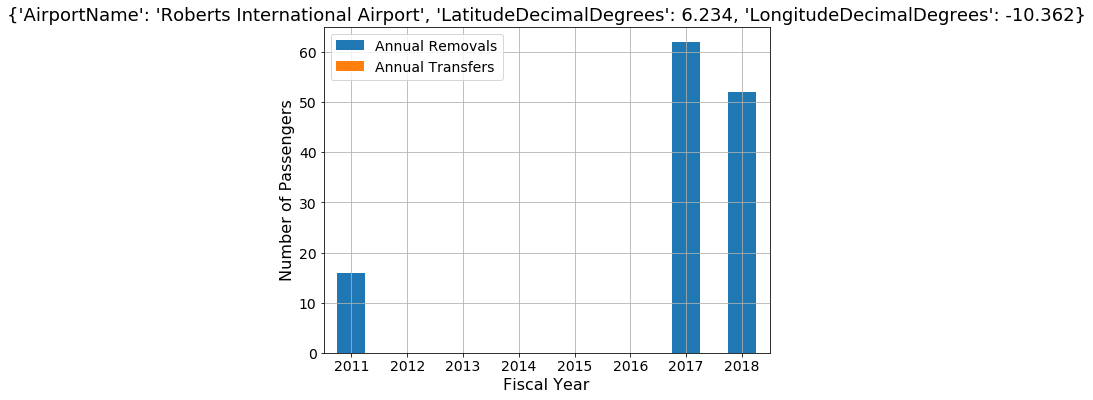

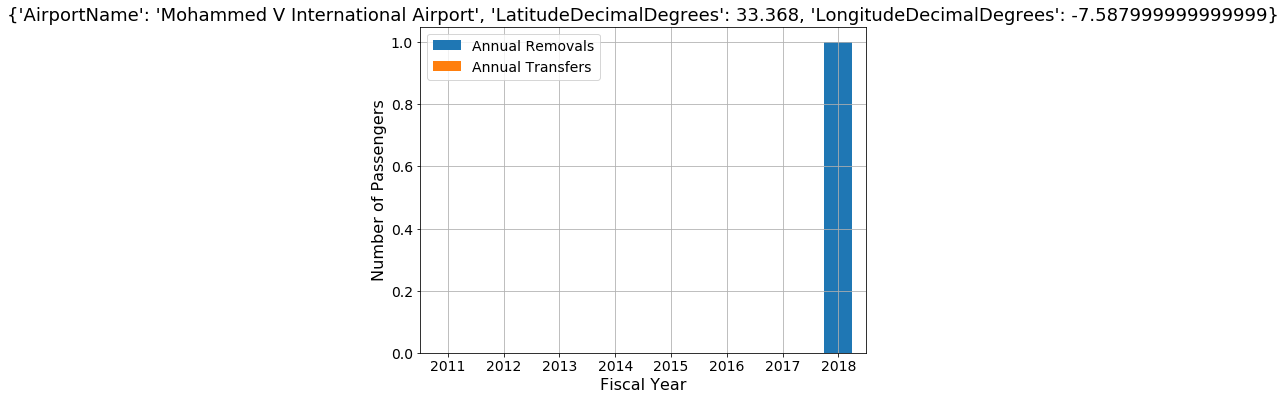

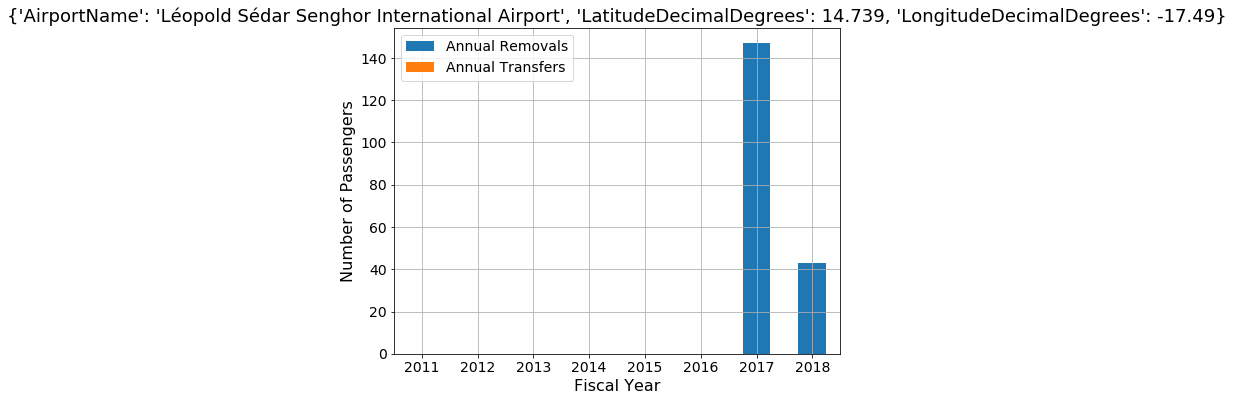

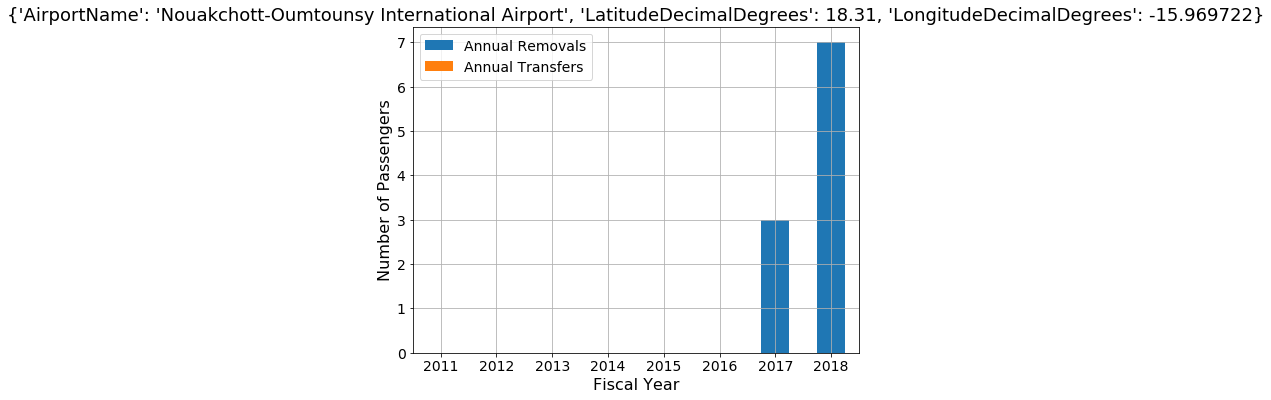

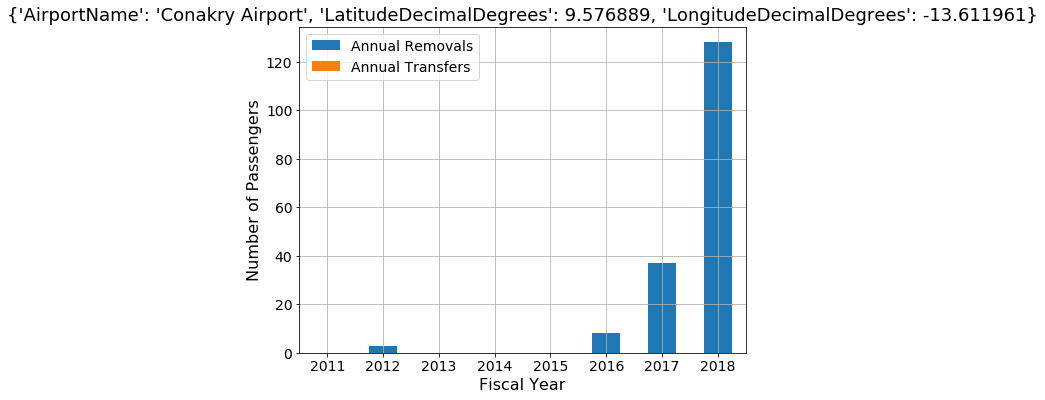

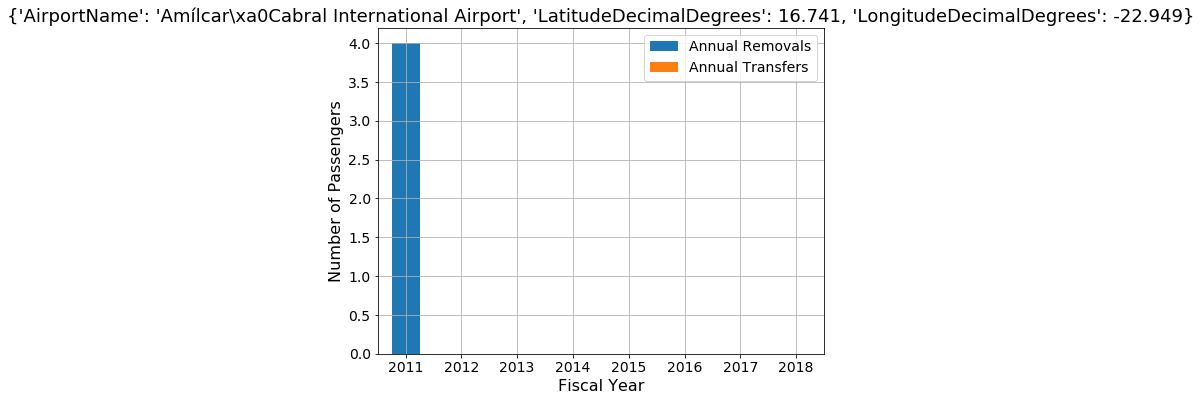

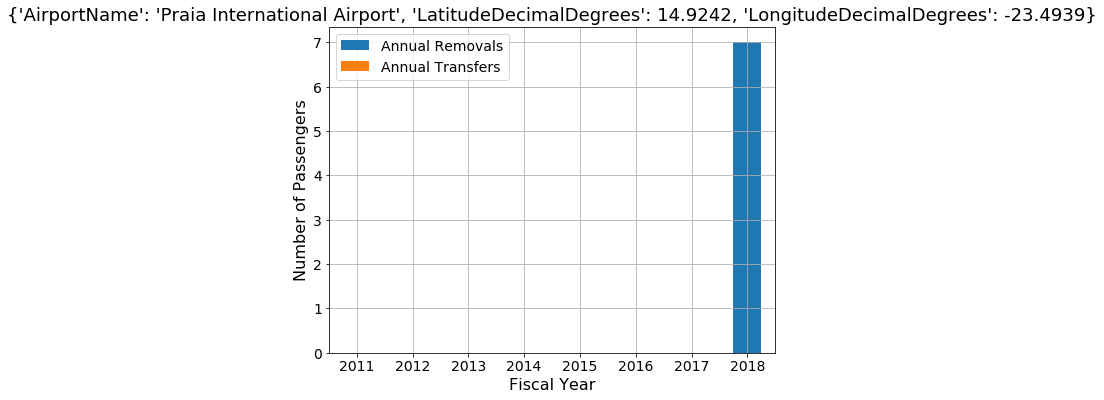

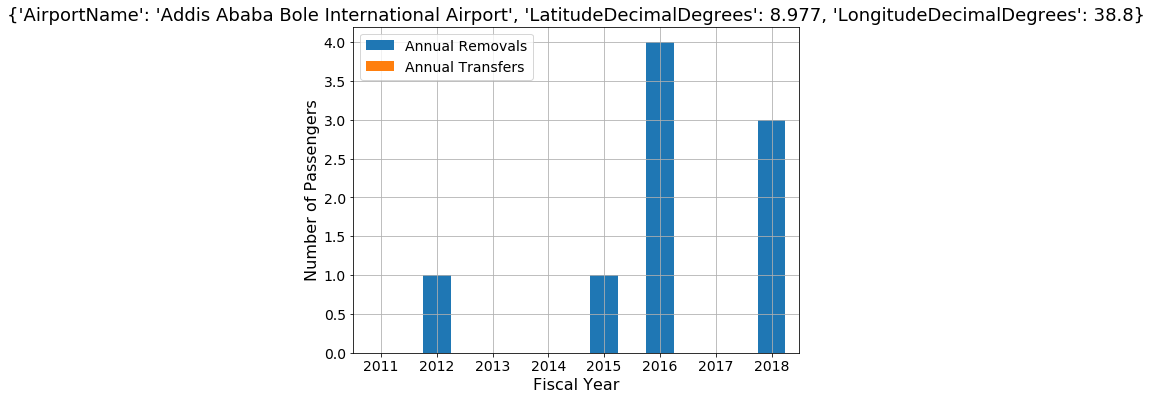

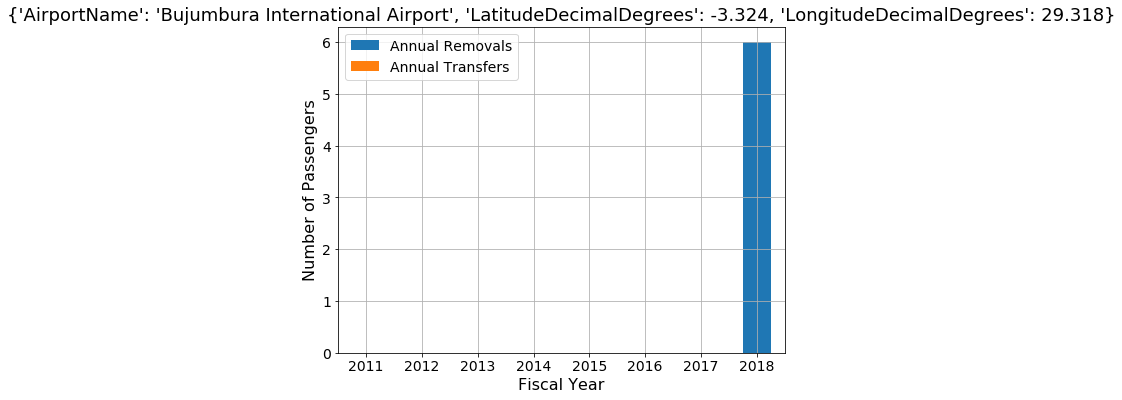

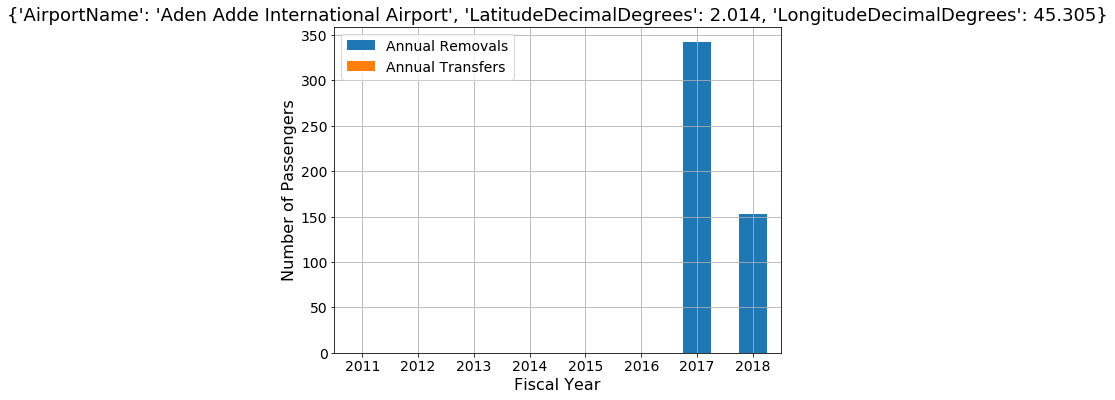

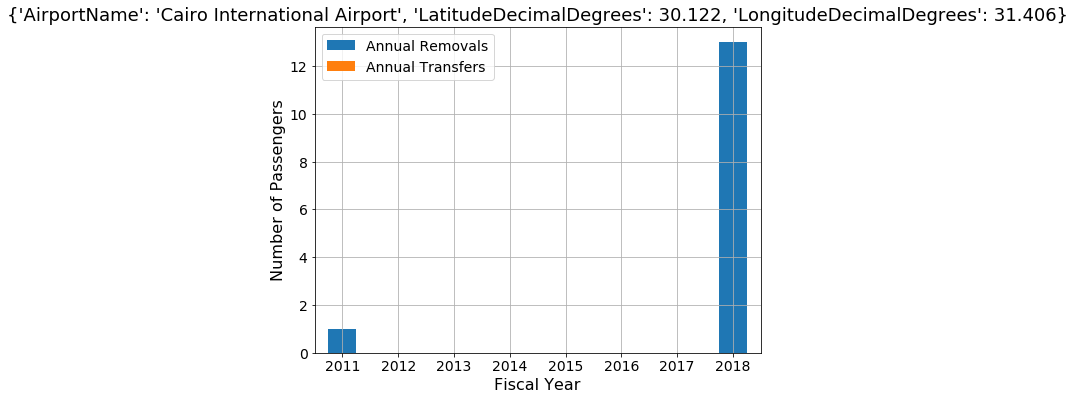

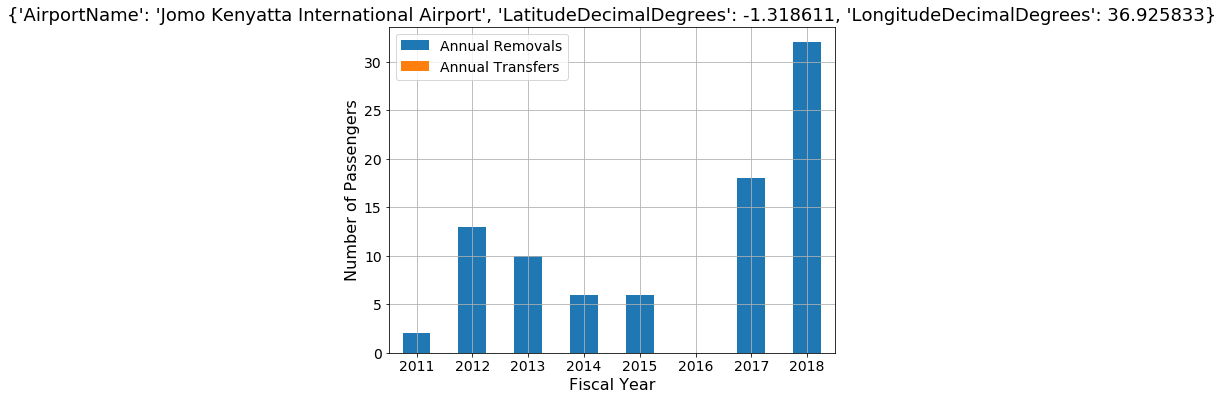

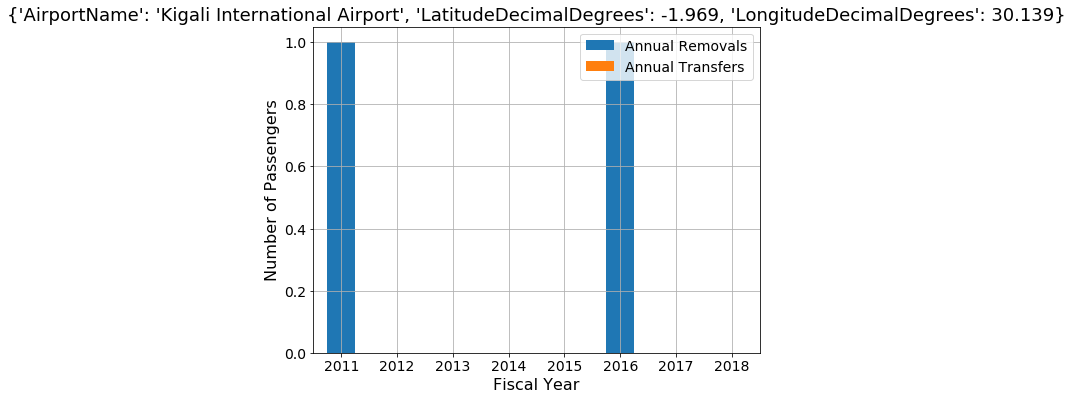

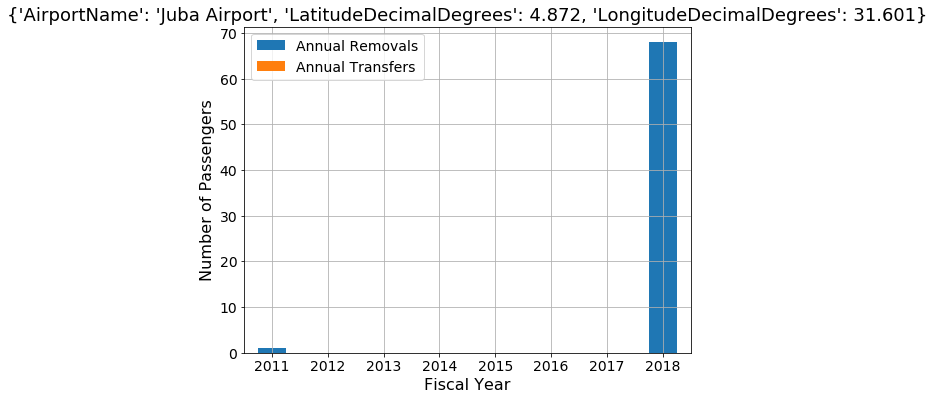

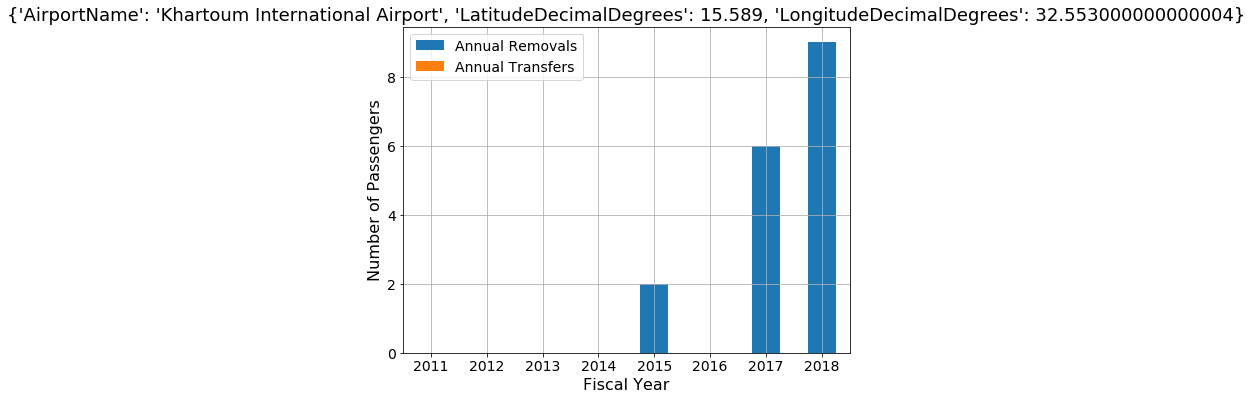

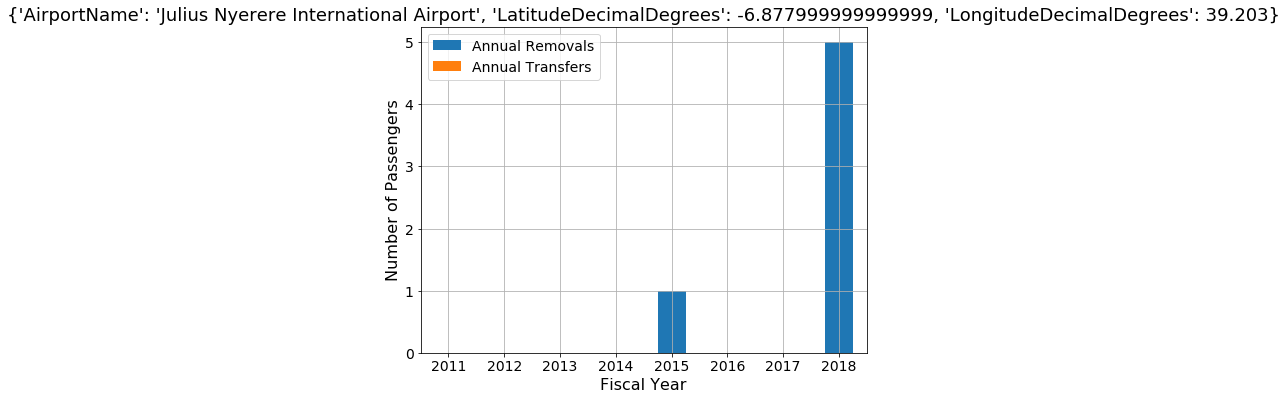

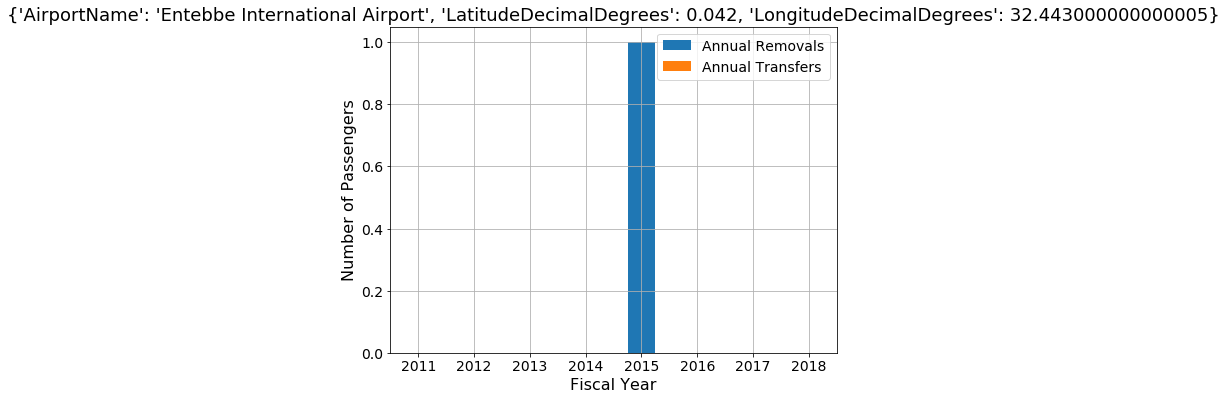

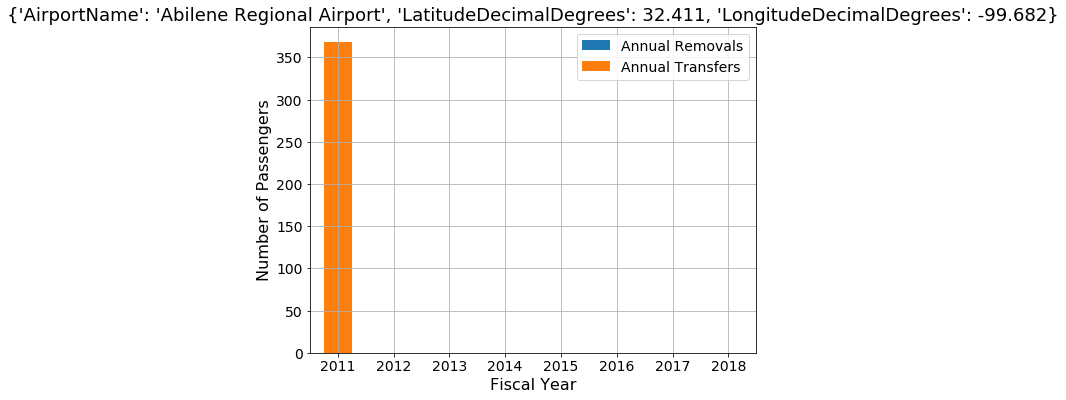

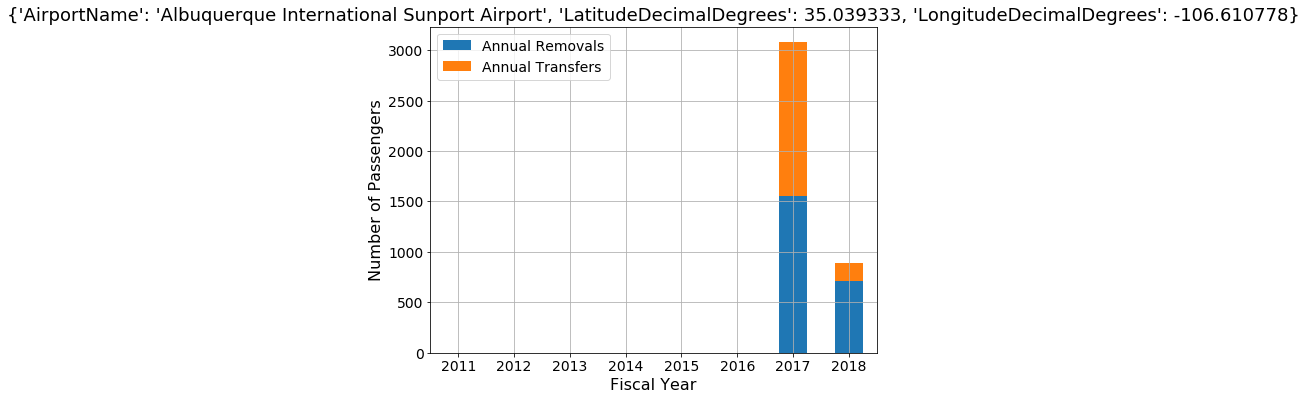

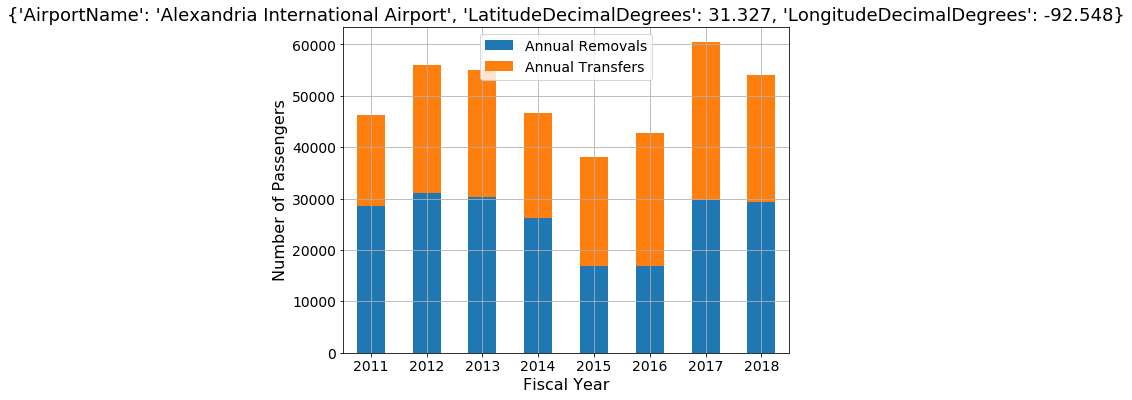

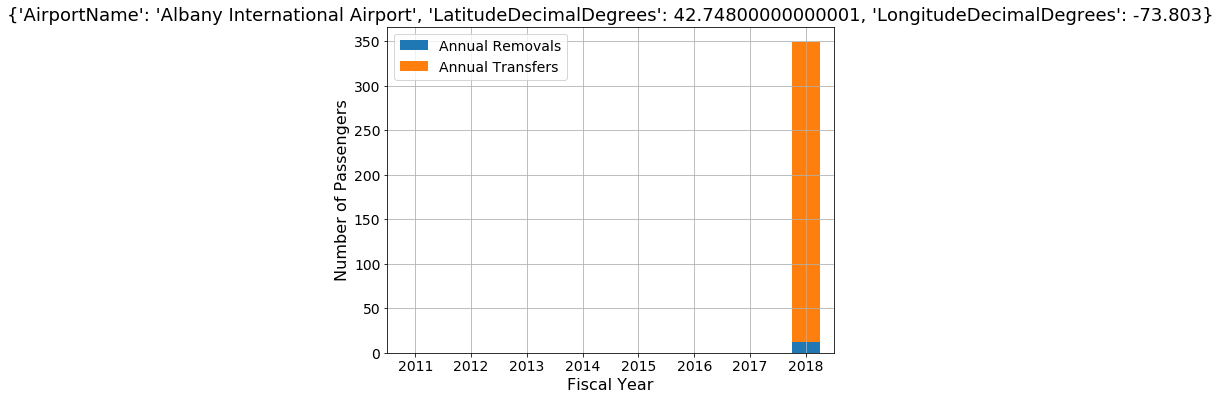

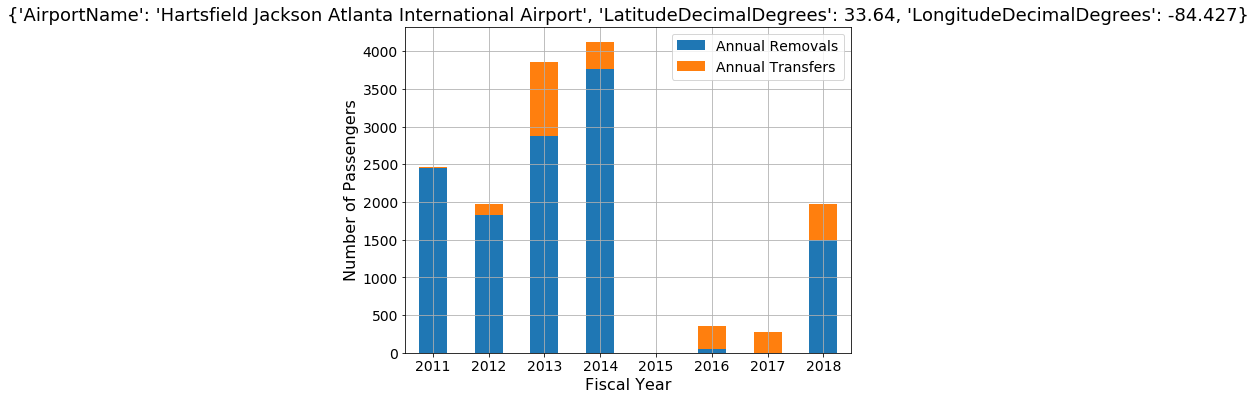

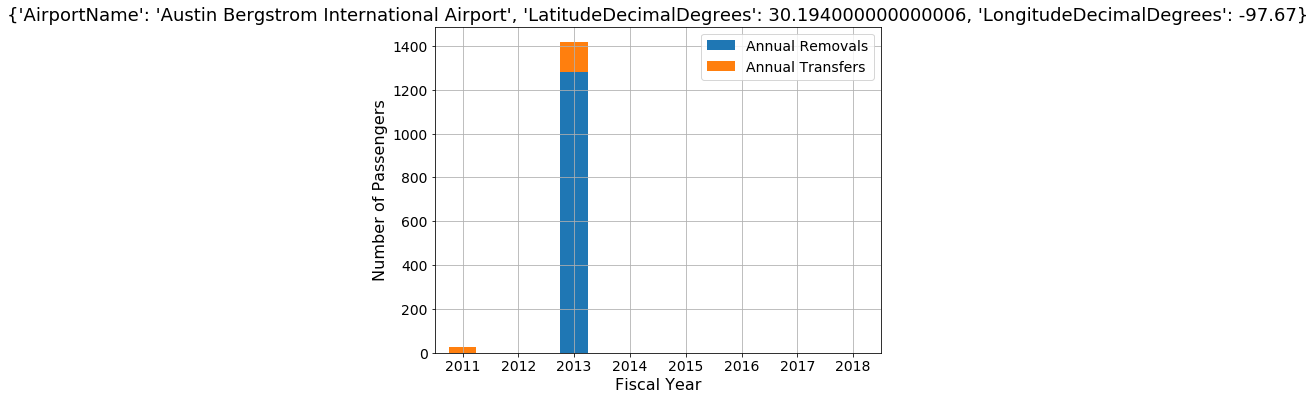

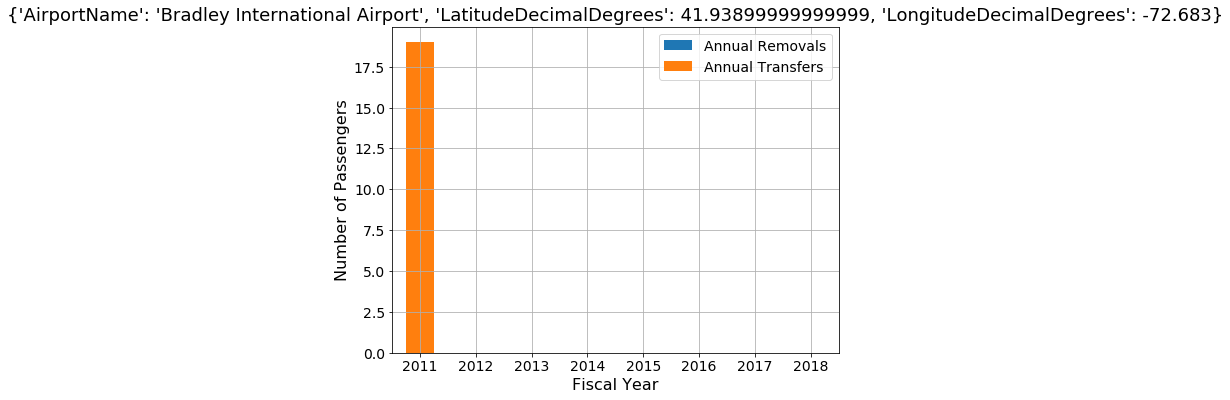

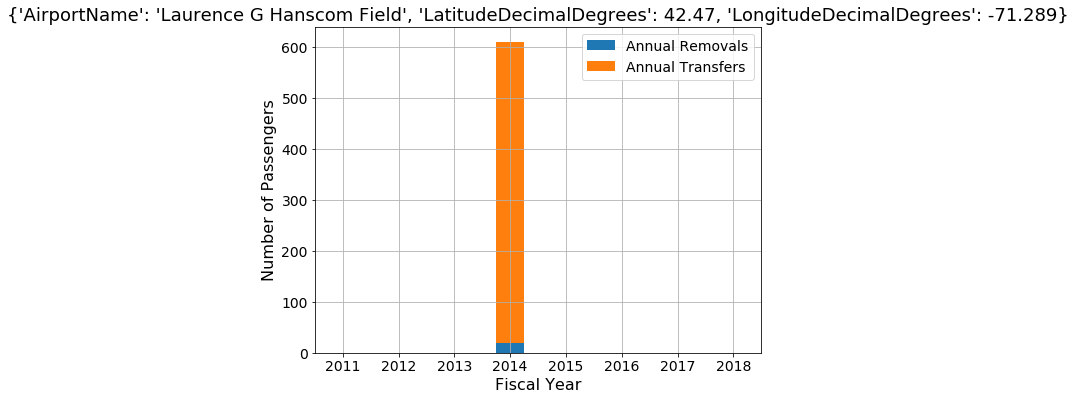

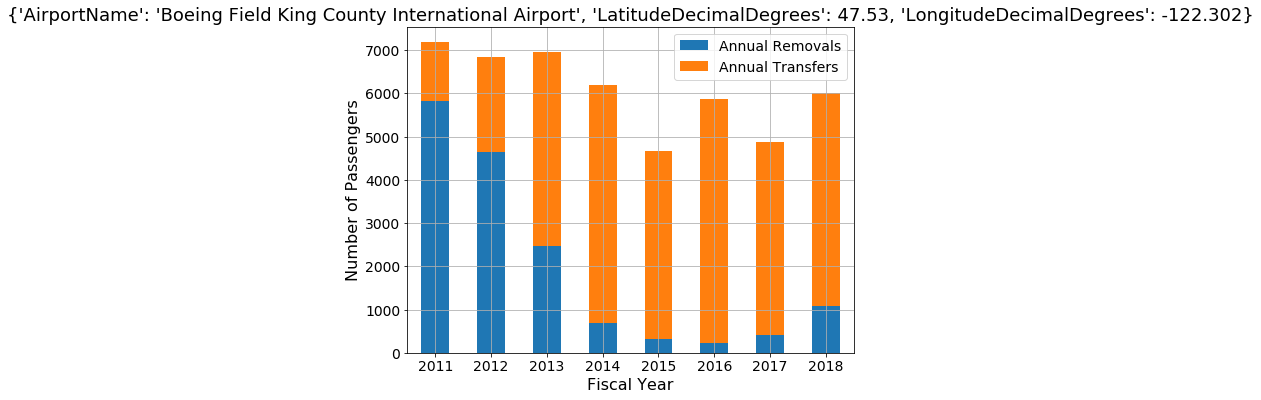

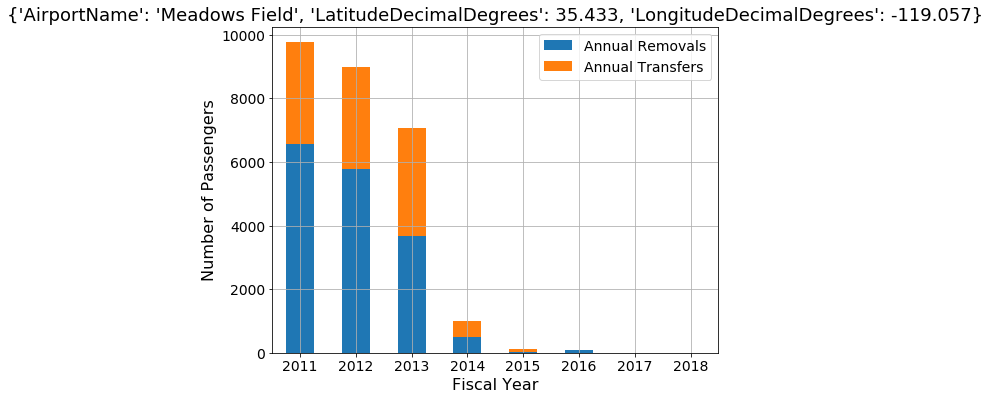

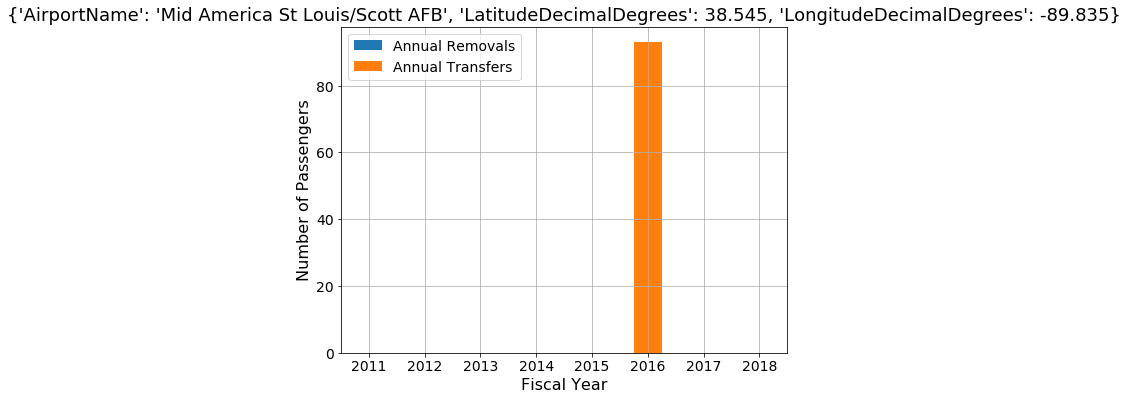

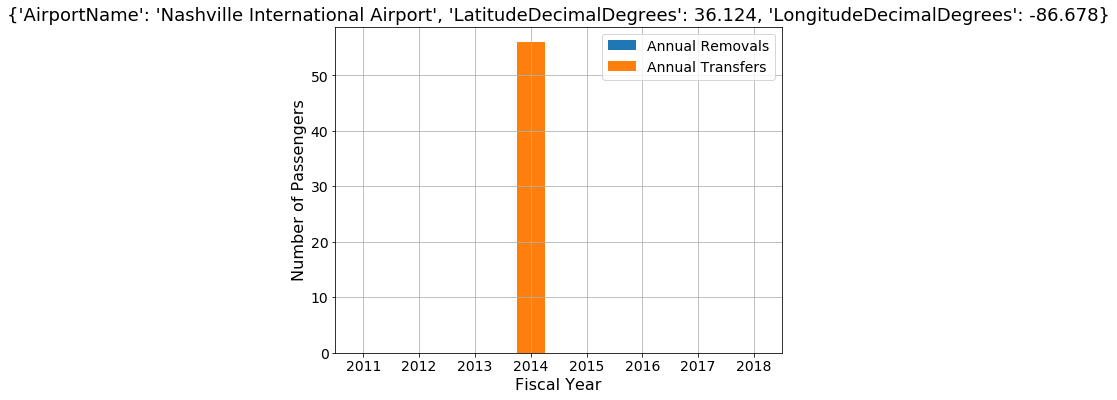

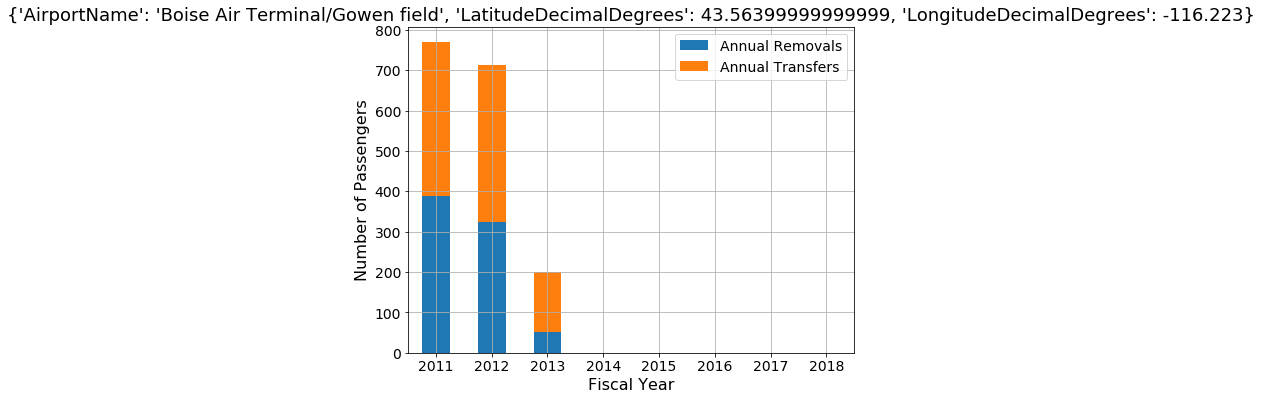

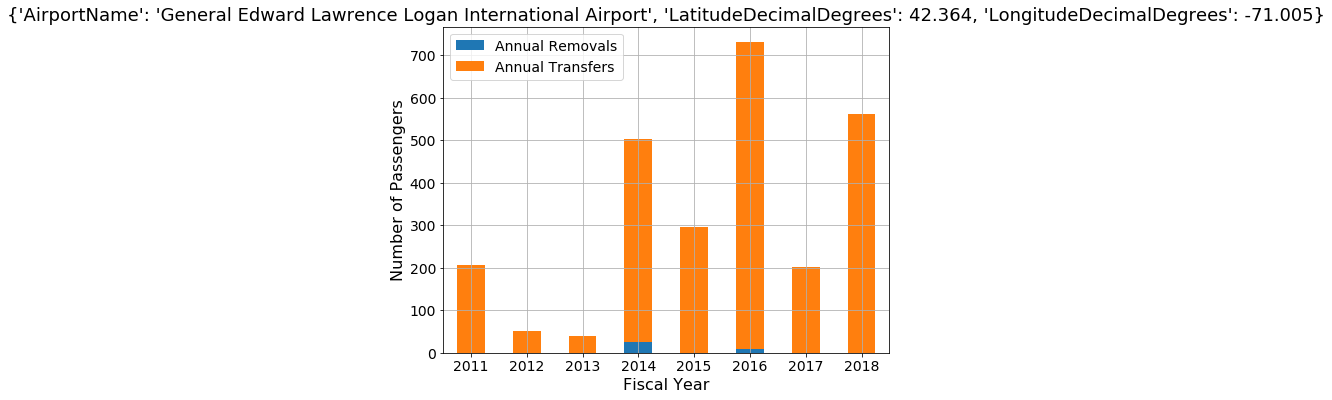

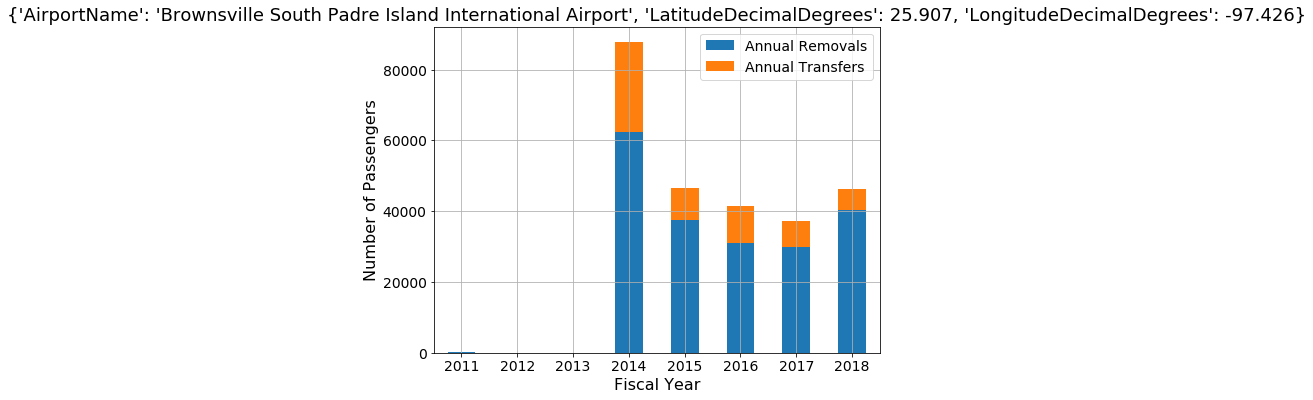

KeyboardInterrupt: 

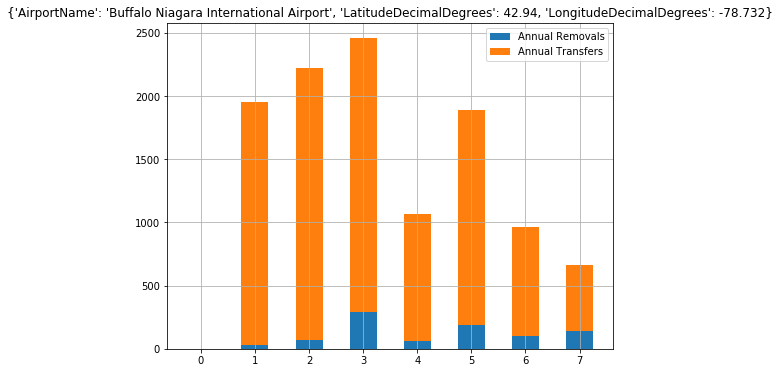

In [76]:
for key in airport_dict.keys():
    try:
        airport_report(airport_icao=key, figure=True)
    except AttributeError:
        pass

In [ ]:
all_missions.tail(10)

In [ ]:
df[df['DropLoc'] == 'KELP']['R-T'].value_counts()